# Investment Analysis Project

- Assignee: Anna Benešová
- Date: 3.1.2025
- Subject: NMFP533

In [248]:
## Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from scipy.optimize import minimize
import statsmodels.api as sm
import seaborn as sns
from tabulate import tabulate
import matplotlib.dates as mdates

In [44]:
# Additional instalations
#pip install seaborn
#pip install yfinance
#pip install tabulate
#pip install statsmodels

### Instructions

We were tasked with analyzing a set of NASDAQ stocks to construct a market portfolio across four main parts:

1. **Data Processing and Basic Exploration**  
2. **Efficient Frontier, Capital Market Line (CML), and Security Market Line (SML)**  
3. **Markowitz Model**  
4. **Out-of-Sample Investment with Initial Capital of \$100,000 USD**  

The assigned stocks are provided in the table below together with brief information about sector and S&P 500 status.  

| Ticker | Company             | Included in S&P 500 | Sector                 |  
| ------ | ------------------- | ------------------- | ---------------------- |  
| GOOGL  | Alphabet            | Yes                 | Communication Services |  
| AMGN   | Amgen               | Yes                 | Health Care            |  
| AVGO   | Broadcom            | Yes                 | Information Technology |  
| DLTR   | Dollar Tree         | Yes                 | Consumer Discretionary |  
| ISRG   | Intuitive Surgical  | Yes                 | Health Care            |  
| LULU   | Lululemon Athletica | Yes                 | Consumer Discretionary |  
| QCOM   | Qualcomm            | Yes                 | Information Technology |  
| TXN    | Texas Instruments   | Yes                 | Information Technology |  

# 1. Data Processing and Basic Exploration

In this section, we will focus on data loading, essential preprocessing, and conducting basic exploratory analysis through plots and descriptive statistics.

## 1.1 Data Processing

### 1.1.1 Data Loading

For data acquisition, we utilized the *yfinance* library to retrieve historical stock prices spanning from January 1, 2021, to October 25, 2024. The data quality assessment revealed complete and consistent records with no anomalous values or irregularities. In accordance with the assignment requirements, we also obtained U.S. Treasury Bond data for the corresponding period, specifically selecting the one-month Treasury bill rate as our risk-free rate $r_f$.

Daily returns $Y_j$ of stock j were calculated using the logarithm of the ratio between closing ($X^c_j$) and opening prices ($X^o_j$):

$$ Y_j = \log\left(\frac{X^c_j}{X^o_j} \right) $$



The logarithmic returns were chosen over simple returns for several key advantages:
1. They are additive over time, making them more suitable for time series analysis
2. They typically exhibit better statistical properties, including closer approximation to normal distribution
3. They prevent stock prices from becoming negative in theoretical models
4. They provide better handling of compounding effects

The annual risk-free rate ($r^{annual}_f$) was converted to a daily rate ($r_f$) using:

$$ r_f = \frac{\log(1 + \frac{r^{annual}_f}{100})}{252} $$

This logarithmic transformation is preferred over simple division by 252 trading days because it accounts for continuous compounding and maintains consistency with our logarithmic returns framework, ensuring more accurate risk-adjusted performance metrics.

### 1.1.2 Data Validation and Structure
We implemented two complementary data structures for our analysis:
1. An aggregated DataFrame of daily returns for all stocks, enabling efficient portfolio-level calculations and cross-sectional analysis
2. A dictionary with stock tickers as keys, facilitating individual stock analysis and maintaining data organization

During the validation process, we identified several dates where certain stocks had missing or inconsistent data. Using a custom validation function, we detected few dates with discrepancies. To maintain data integrity and prevent bias in our analysis, these dates were excluded from the dataset. The specific dates and affected stocks are detailed below:

In [187]:
def download_stock_data(stock_files, output_dir):
    """
    Download historical stock data using yfinance and save to CSV files with consistent date formatting.
    
    Parameters:
    stock_files (dict): Dictionary with stock tickers as keys and output filenames as values
    output_dir (str): Directory to save the CSV files
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Calculate date range (for the assignment period)
    start_date = '2021-01-01'  # January 1, 2021
    end_date = '2024-10-26'    # October 26, 2024
    
    # Download data for each ticker
    for ticker, filename in stock_files.items():
        try:
            # Get stock data
            stock = yf.Ticker(ticker)
            df = stock.history(start=start_date, end=end_date)
            
            # Convert index to date format without time component
            df.index = df.index.date
            
            # Name the index column
            df.index.name = 'Date'
            
            # Save to CSV
            output_path = os.path.join(output_dir, filename)
            df.to_csv(output_path)
            #print(f"Successfully downloaded data for {ticker} to {filename}")
            
        except Exception as e:
            print(f"Error downloading data for {ticker}: {str(e)}")
            
# When reading the CSV files back, use:
# df = pd.read_csv(file_path, parse_dates=True, index_col='Date')

In [188]:
# Define the directory containing your stock data
data_dir = r"C:\Users\Uzivatel\Documents\ds2-hw\Projekt -AnalyzaInvestic\stock_data" #changable

# ABE tickers, all well defined
stock_files = {
    'GOOGL': 'Alphabet A Stock Price History.csv',
    'AMGN': 'Amgen Stock Price History.csv',
    'AVGO': 'Broadcom Stock Price History.csv',
    'DLTR': 'Dollar Tree Stock Price History.csv',
    'ISRG': 'Intuitive Surgical Stock Price History.csv',
    'LULU': 'Lululemon Athletica Stock Price History.csv',
    'QCOM': 'Qualcomm Stock Price History.csv',
    'TXN': 'Texas Instruments Stock Price History.csv',
}

# Dir for risk free asset
risk_free_file = r'C:\Users\Uzivatel\Documents\ds2-hw\Projekt -AnalyzaInvestic\USYields2024.csv'

In [189]:
# Downloading data
stock_data = download_stock_data(stock_files,'stock_data')

In [190]:
# Function to calculate daily returns
def calculate_daily_returns(data):
    """
    Calculates daily returns as the logarithm of the ratio of Price to Open prices.
    """
    data['Daily_Return'] = np.log(data['Close'] / data['Open']) # log(Close/Open)
    return data[['Date', 'Daily_Return']]

In [10]:
# Load and process stock data

daily_returns = {} # Table with all daily returns in one place
all_data = {}  # Dictionary with ticker as key

for ticker, file_name in stock_files.items():
    file_path = os.path.join(data_dir, file_name)
    #print(f"Processing data for {ticker} from {file_path}...")
    data = pd.read_csv(file_path, parse_dates=['Date'])
    data['Ticker'] = ticker  # Add a column for the ticker
    daily_returns[ticker] = calculate_daily_returns(data).set_index('Date')
    all_data[ticker] = data  # Store the full data in the dictionary

# Combine daily returns into a single DataFrame
combined_returns = pd.concat(
    [df['Daily_Return'].rename(ticker) for ticker, df in daily_returns.items()],
    axis=1
)

In [185]:
sp500_data = yf.download('^GSPC', start='2022-10-24', end='2024-10-25')

[*********************100%***********************]  1 of 1 completed


In [191]:
# Preprocessing of risk_free_file
risk_free_rate = pd.read_csv(risk_free_file)

# Remove leading/trailing spaces from column names
risk_free_rate.columns = risk_free_rate.columns.str.strip()

# Convert Date column to datetime format with dayfirst=True
risk_free_rate['Date'] = pd.to_datetime(risk_free_rate['Date'], dayfirst=True, errors='coerce')

# Ensure the '1 Mo' column is numeric and handle missing values
risk_free_rate['1 Mo'] = pd.to_numeric(risk_free_rate['1 Mo'], errors='coerce')

# Check if 'Date' column exists and proceed
if 'Date' in risk_free_rate.columns:
    # Filter columns
    risk_free_rate = risk_free_rate[['Date', '1 Mo']].dropna()

    # Filter date range
    mask = (risk_free_rate['Date'] >= '2021-01-01') & (risk_free_rate['Date'] <= '2024-10-25')
    risk_free_rate = risk_free_rate.loc[mask]

    # Convert the annualized rate into a daily rate (assuming 252 trading days in a year)
    #risk_free_rate['Daily_Risk_Free_Rate'] = (1 + risk_free_rate['1 Mo'] / 100) ** (1 / 252) - 1 #????
    risk_free_rate['Daily_Risk_Free_Rate'] = np.log(1 + risk_free_rate['1 Mo'] / 100)  / 252

    # Set the 'Date' column as the index for alignment with stock data
    risk_free_rate.set_index('Date', inplace=True)

    #print("\nRisk-Free Rate Data (Head):")
    #print(risk_free_rate.head())
    #print("\nRisk-Free Rate Data (Tail):")
    #print(risk_free_rate.tail())
    #print("\nDate range in the data:")
    #print(f"Start date: {risk_free_rate.index.min()}")
    #print(f"End date: {risk_free_rate.index.max()}")

    # Save the processed risk-free rate for later use
    risk_free_rate.to_csv('processed_risk_free_rate.csv')
    #print("Risk-free rate processing complete. File saved as 'processed_risk_free_rate.csv'.")
else:
    print("The 'Date' column is missing or misnamed.")
#TODO hide

In [192]:
def compare_and_clean_dates(combined_returns, risk_free_rate):
    """
    Compare and clean dates between two dataframes, removing time components
    and handling timezone differences.
    
    Parameters:
    combined_returns (pd.DataFrame): DataFrame with potential timezone-aware dates
    risk_free_rate (pd.DataFrame): DataFrame with datetime index
    
    Returns:
    tuple: (missing_dates, cleaned_combined_returns, cleaned_risk_free_rate)
    """
    # Convert combined returns dates - handle timezone aware dates
    combined_dates = combined_returns.index.tz_localize(None)  # Remove timezone first
    combined_dates = pd.to_datetime(combined_dates).date  # Then convert to date
    
    # Convert risk free dates
    risk_free_dates = pd.to_datetime(risk_free_rate.index).date
    
    # Find missing dates
    combined_dates_set = set(combined_dates)
    risk_free_dates_set = set(risk_free_dates)
    missing_dates = sorted(combined_dates_set - risk_free_dates_set)
    missing_dates2 = sorted(risk_free_dates_set- combined_dates_set )
    
    # Create new DataFrames with clean dates
    cleaned_combined_returns = combined_returns.copy()
    cleaned_combined_returns.index = combined_dates
    
    cleaned_risk_free_rate = risk_free_rate.copy()
    cleaned_risk_free_rate.index = risk_free_dates
    
    return missing_dates, missing_dates2, cleaned_combined_returns, cleaned_risk_free_rate



In [193]:
# Usage example:
missing_dates, missing_dates2, clean_returns, clean_risk_free = compare_and_clean_dates(combined_returns, risk_free_rate)
# Cleaning combined
#combined_returns_cleaned = combined_returns[~combined_returns.index.isin(missing_dates)]
# Print missing dates
print("Missing Dates in Risk-Free Rate Data:")
for date in missing_dates:
    print(date)
print("Missing Dates in Combo Rate Data:")
for date in missing_dates2:
    print(date)

# Print sample of cleaned dates
print("\nSample of Cleaned Combined Returns Dates:")
print(clean_returns.index[:5])
print("\nSample of Cleaned Risk-Free Dates:")
print(clean_risk_free.index[:5])

Missing Dates in Risk-Free Rate Data:
2021-10-11
2021-11-11
2022-10-10
2022-11-11
2023-10-09
2024-10-14
Missing Dates in Combo Rate Data:
2021-04-02
2023-04-07

Sample of Cleaned Combined Returns Dates:
Index([2021-01-04, 2021-01-05, 2021-01-06, 2021-01-07, 2021-01-08], dtype='object')

Sample of Cleaned Risk-Free Dates:
Index([2021-01-04, 2021-01-05, 2021-01-06, 2021-01-07, 2021-01-08], dtype='object')


In [194]:
# Ensure missing_dates are datetime64[ns]
missing_dates = pd.to_datetime(missing_dates)

# Now apply to combined_returns
combined_returns_cleaned = combined_returns[~combined_returns.index.isin(missing_dates)]

# Similarly for risk_free_rate
missing_dates2 = pd.to_datetime(missing_dates2)
risk_free_rate_cleaned = risk_free_rate[~risk_free_rate.index.isin(missing_dates2)]

## 1.2  Data Exploration

### 1.2.1 Desctiptive Statistics

First, we showcase an overview of common descriptive statistics of combined returns $Y$ and $r_f$. Notice all have the same count (954) indicating correct data loading and alignment across the assets.

The expected returns show the average daily returns for the assets. **GOOGL** ($\mu_{GOOGL}=0.00061$) and AVGO ($\mu_{AVGO}=0.00041$) exhibit positive expected returns, indicating slight daily growth, while other assets like **AMGN** ($\mu_{AMGN}=-0.00012$) and LULU ($\mu_{LULU}=-0.00067$) show negative expected returns, suggesting slight daily losses.

As for the covariance matrix, we can spot notable patterns include **GOOGL** having relatively high covariance with **AVGO** (0.00014), suggesting these tech stocks tend to move together. **ISRG** shows the highest variance ($\sigma_{ISRG}^2=0.00027$) among all assets, indicating greater price volatility.

Looking at the daily returns summary, we observe wide ranges in returns across assets. For instance, **ISRG** shows the highest maximum daily return (0.0799) while **QCOM** experienced the lowest minimum return (-0.0783). The risk-free rate averages around 2.96% annually (with a daily rate of 0.00011), providing context for evaluating expected returns.

The distribution of returns appears slightly asymmetric, as evidenced by the differences between mean ($\mu$) and median ($m$) values across assets, suggesting potential skewness in daily returns that could be relevant for risk management considerations.

In [195]:
# Summary of Risk-Free Rate and combined Results
print("\nDaily Returns Summary:")
#print(combined_returns_cleaned.describe())
print(tabulate(combined_returns_cleaned.describe(), headers='keys', tablefmt='psql'))
print("\nRisk-Free Rate Summary:")
#print(risk_free_rate_cleaned.describe()
print(tabulate(risk_free_rate_cleaned.describe(), headers='keys', tablefmt='psql'))


Daily Returns Summary:
+-------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
|       |         GOOGL |          AMGN |          AVGO |          DLTR |          ISRG |          LULU |          QCOM |           TXN |
|-------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------|
| count | 954           | 954           | 954           | 954           | 954           | 954           | 954           | 954           |
| mean  |   0.000614421 |  -0.000123003 |   0.000411028 |  -1.88336e-05 |   6.55437e-05 |  -0.000671316 |  -0.000210069 |  -4.39508e-05 |
| std   |   0.0147859   |   0.0116044   |   0.019039    |   0.0171943   |   0.0165091   |   0.0187665   |   0.0188644   |   0.0142204   |
| min   |  -0.0535842   |  -0.0642703   |  -0.0842618   |  -0.135594    |  -0.0859937   |  -0.0826475   |  -0.078268    |  -0.0535006   |
| 25%   | 

In [196]:
#print("\n First 5 rows")
#print(combined_returns_cleaned.head())
#print("\n Last 5 rows")
#print(risk_free_rate_cleaned.tail())

In [197]:
# Exploratory analysis

#print("Performing exploratory analysis...")
mean_returns = combined_returns_cleaned.mean()
mean_returns_df = pd.DataFrame(mean_returns).reset_index()
mean_returns_df.columns = ['Ticker', 'Expected Returns']

cov_matrix = combined_returns_cleaned.cov()
auto_cov = combined_returns_cleaned.apply(lambda col: col.autocorr())
auto_cov_df = pd.DataFrame(mean_returns).reset_index()
auto_cov_df.columns = ['Ticker', 'Autocorrelations']


print("\nExpected Returns (Mean):")
print(tabulate(mean_returns_df, headers='keys', tablefmt='psql'))
print("\nCovariance Matrix:")
print(tabulate(cov_matrix,headers='keys', tablefmt='psql'))
print("\nAuto-covariances (Autocorrelations):")
print(tabulate(auto_cov_df,headers='keys', tablefmt='psql'))


Expected Returns (Mean):
+----+----------+--------------------+
|    | Ticker   |   Expected Returns |
|----+----------+--------------------|
|  0 | GOOGL    |        0.000614421 |
|  1 | AMGN     |       -0.000123003 |
|  2 | AVGO     |        0.000411028 |
|  3 | DLTR     |       -1.88336e-05 |
|  4 | ISRG     |        6.55437e-05 |
|  5 | LULU     |       -0.000671316 |
|  6 | QCOM     |       -0.000210069 |
|  7 | TXN      |       -4.39508e-05 |
+----+----------+--------------------+

Covariance Matrix:
+-------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|       |       GOOGL |        AMGN |        AVGO |        DLTR |        ISRG |        LULU |        QCOM |         TXN |
|-------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------|
| GOOGL | 0.000218624 | 2.98022e-05 | 0.000140792 | 4.83033e-05 | 0.000120249 | 0.000128083 | 0.000149259 | 0.000105315 

### 1.2.2 Visualization

Daily returns visualization reveals distinct volatility patterns across our stock portfolio. **GOOGL** exhibits clear heteroskedasticity with volatility clustering in 2022, accompanied by mild return autocorrelation during this highly volatile period. In contrast, **AMGN** demonstrates more homoskedastic behavior, interrupted only by notable negative spikes in Q1 2024.

**AVGO** and **ISRG** share similar patterns but with different timing of volatile periods - **AVGO** showing increased volatility in 2024 with positive directional bias, while **ISRG** experienced heightened volatility in Q1 2022 during healthcare sector uncertainty (COVID). **DLTR** stands out with remarkably low baseline volatility, broken by extreme bidirectional spikes in Q3 2024.

**LULU** mirrors **ISRG's** pattern but with more pronounced negative spikes, while **QCOM** and **TXN** display relatively stable patterns with **QCOM** showing increased volatility in late 2024 and **TXN** exhibiting more pronounced movements early in the sample period.

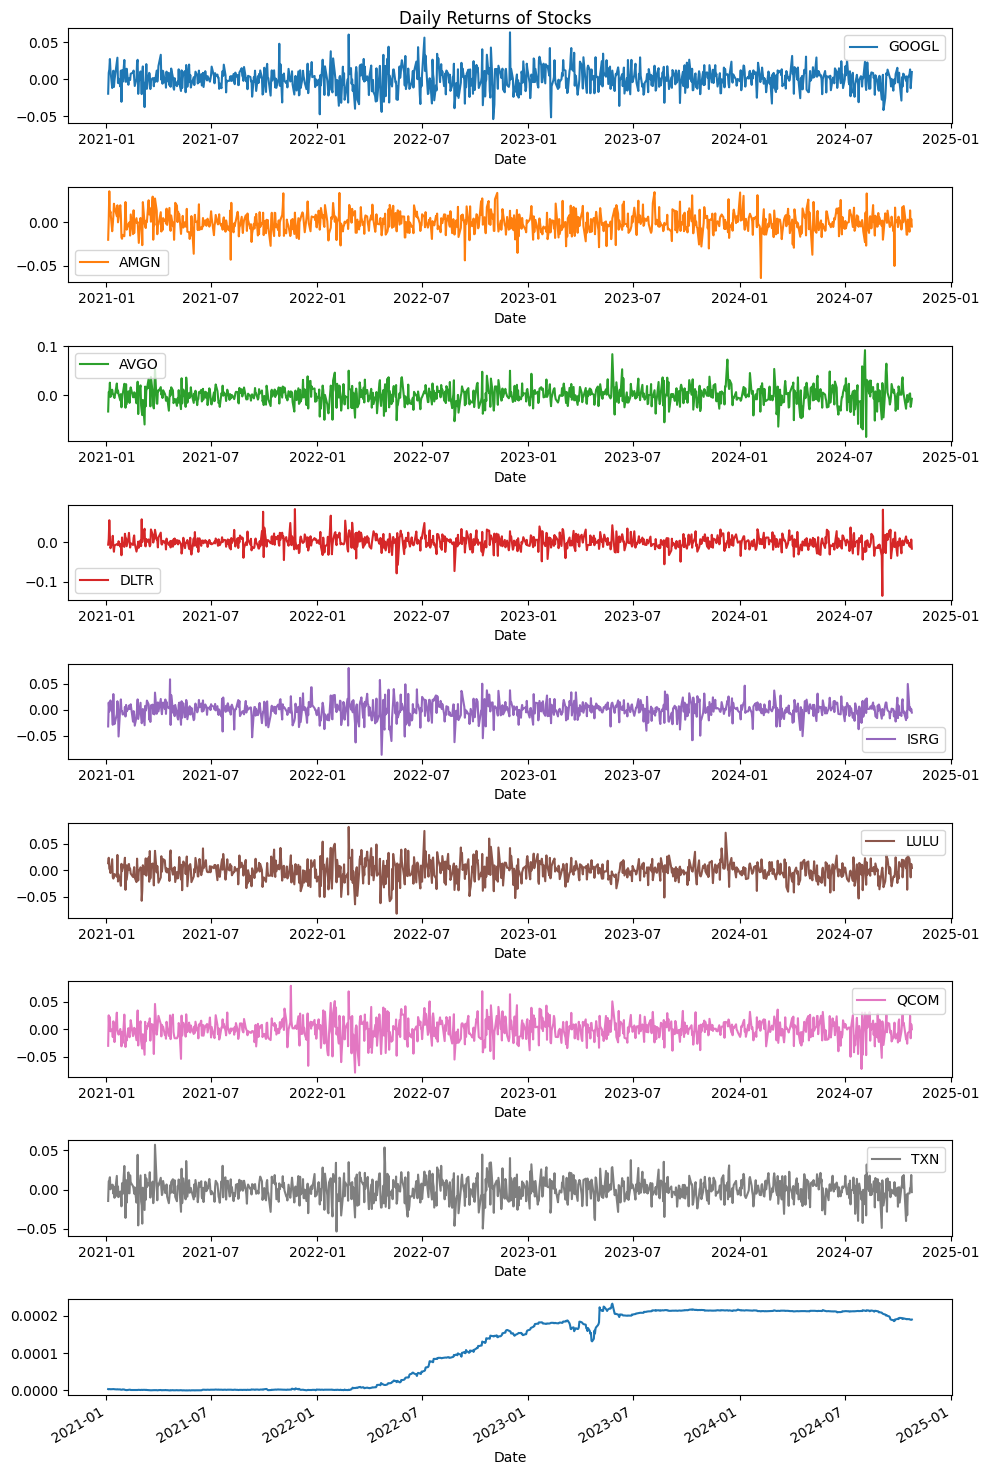

In [198]:
# Plotting daily returns
# Create a subplot for combined_returns_cleaned
fig, axes = plt.subplots(len(combined_returns_cleaned.columns) + 1, 1, figsize=(10, 15))

# Plot the daily returns of stocks
combined_returns_cleaned.plot(subplots=True, ax=axes[:len(combined_returns_cleaned.columns)], title='Daily Returns of Stocks')

# Plot the daily risk-free rate as the last subplot
risk_free_rate_cleaned['Daily_Risk_Free_Rate'].plot(ax=axes[len(combined_returns_cleaned.columns)])

# Adjust layout to make sure it looks nice
plt.tight_layout()

# Show the plot
plt.show()

In [199]:
#combined_returns.info()
#combined_returns.shape

In [253]:
def explore_data(stock_data):
    """
    Explore the downloaded stock data with various analyses.
    
    Parameters:
    stock_data (dict): Dictionary with stock tickers as keys and pandas DataFrames as values
    """
    print("\n=== Data Exploration ===")
    
    # Define color palettes
    plot_color = '#1f77b4'  # Blue for the stock price plot
    return_color = '#ff7f0e'  # Orange for the daily return distribution plot
    
    for ticker, df in stock_data.items():
        print(f"\nAnalysis for {ticker}:")
        print("-" * 50)
        
        # Summary statistics with colorized output
        print("\nSummary Statistics:")
        print(tabulate(df.describe(), headers='keys', tablefmt='psql')) # Blue-colored table output
        
        # Check for missing values
        missing = df.isnull().sum()
        if missing.any():
            print("\n\033[91mMissing Values:\033[0m")  # Red for missing values
            print(missing[missing > 0])
        
        # Calculate daily returns
        df['Daily_Return'] = np.log(df['Close']) - np.log(df['Open'])
        
        # Basic metrics
        print("\nKey Metrics:")
        print(f"Total Trading Days: {len(df)}")
        print(f"Average Daily Volume: {df['Volume'].mean():,.0f}")
        print(f"Average Daily Return: \033[92m{df['Daily_Return'].mean():.4%}\033[0m")  # Green for positive returns
        print(f"Return Volatility: {df['Daily_Return'].std():.4%}")
        print(f"Maximum Daily Gain: \033[92m{df['Daily_Return'].max():.4%}\033[0m")  # Green for gains
        print(f"Maximum Daily Loss: \033[91m{df['Daily_Return'].min():.4%}\033[0m")  # Red for losses
        
        # Plot price history with a custom color
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df['Close'], color=plot_color)
        plt.title(f'{ticker} Stock Price History', color=plot_color)
        plt.xlabel('Date', color=plot_color)
        plt.ylabel('Price', color=plot_color)
        plt.grid(True)
        plt.xticks(color=plot_color)
        plt.xticks(color=plot_color)  # Rotate for better readability
        plt.show()
        
        # Plot daily returns distribution with a custom color
        plt.figure(figsize=(10, 6))
        sns.histplot(df['Daily_Return'], kde=True, color=return_color)
        plt.title(f'{ticker} Daily Returns Distribution', color=return_color)
        plt.xlabel('Daily Return', color=return_color)
        plt.ylabel('Frequency', color=return_color)
        plt.xticks(color=return_color)
        plt.yticks(color=return_color)
        plt.show()

In [48]:
#all_data['GOOGL'] #all data in one frame (disctionary)
#combined_returns #This one is more important

In the following script, we used the dictionary dataframe to iteratively explore each stock. The summary statistics include following metrics:

- `Open`: Day's first trade price
- `Close`: Final trading price
- `High/Low`: Price extremes during session
- `Volume`: Number of shares traded
- `Dividends`: Cash distributions to shareholders
- `Stock Splits`: Share quantity adjustments
- `Daily Returns`: Log returns of the ratio of `Close` and `Open`

Distribution analysis reveals some leptokurtic tendencies across all stocks, with **DLTR** exhibiting the highest kurtosis.


Trading volumes showcase significant disparities:
- **GOOGL**: Highest volume (25x peers omitting **AVGO**) 
- **AVGO**: Second most traded, boosted by semiconductor sector focus
- **ISRG**/**LULU**: Lowest volumes suggesting liquidity constraints

Maximum daily gains were led by **ISRG** (7.99% - possible surgical robot market expansion) while largest losses were seen in **DLTR** (-13.55% - Q4 2024 earnings miss, inflation impact), showcasing the range of price movements in our portfolio.

Daily returns distributions:
- **GOOGL**: Normal distributed
- **AMGN**: Slightly heavier right tail
- **DLTR** and **ISRG**: Heaviest left tails indicating large loss events
- **DLTR**: Shows leptokurtic pattern (higher, sharper peak) suggesting frequent small moves with occasional extreme events

Price history analysis:
- **GOOGL**: Two local maxima, reflecting tech sector trends
- **AMGN**: More volatile pattern with strong upward momentum in 2024
- **AVGO**: Lower volatility historically with steep rise and two significant negative spikes in Q4 2024
- **DLTR**: Shows concerning downward trend in Q4 2024, dropping >30% from peak
- **ISRG**: Similar pattern to **AVGO** with notable dip around day 400
- **QCOM**: Exhibits cyclical pattern with sharp spike in Q3 2024 followed by correction
- **TXN**: Most stable until Q3 2024 when it showed significant upward movement (possibly surge on automotive chip demand) 


=== Data Exploration ===

Analysis for GOOGL:
--------------------------------------------------

Summary Statistics:
+-------+-------------------------------+----------+----------+----------+----------+---------------+---------------+----------------+----------------+
|       | Date                          |     Open |     High |      Low |    Close |        Volume |     Dividends |   Stock Splits |   Daily_Return |
|-------+-------------------------------+----------+----------+----------+----------+---------------+---------------+----------------+----------------|
| count | 960                           | 960      | 960      | 960      | 960      | 960           | 960           |    960         |   960          |
| mean  | 2022-11-29 13:08:59.999999744 | 127.637  | 129.078  | 126.289  | 127.702  |   3.14093e+07 |   0.000416667 |      0.0208333 |     0.00062885 |
| min   | 2021-01-04 00:00:00           |  84.7059 |  86.2075 |  83.039  |  83.1287 |   9.7014e+06  |   0           |    

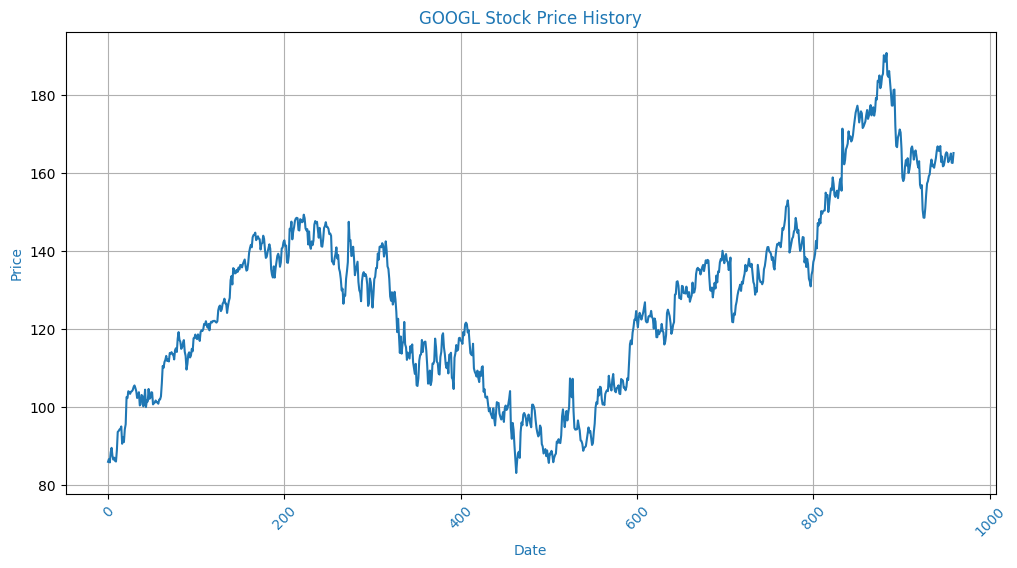

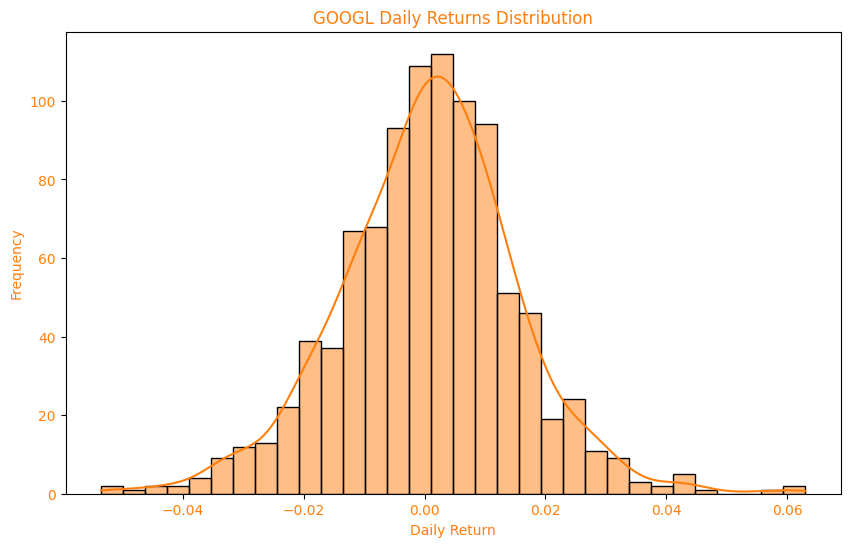


Analysis for AMGN:
--------------------------------------------------

Summary Statistics:
+-------+-------------------------------+----------+----------+----------+----------+------------------+-------------+----------------+----------------+
|       | Date                          |     Open |     High |      Low |    Close |           Volume |   Dividends |   Stock Splits |   Daily_Return |
|-------+-------------------------------+----------+----------+----------+----------+------------------+-------------+----------------+----------------|
| count | 960                           | 960      | 960      | 960      | 960      |    960           | 960         |            960 |  960           |
| mean  | 2022-11-29 13:08:59.999999744 | 241.043  | 243.268  | 238.679  | 241.004  |      2.6413e+06  |   0.0313229 |              0 |   -0.000155592 |
| min   | 2021-01-04 00:00:00           | 182.286  | 184.705  | 180.649  | 180.867  | 930800           |   0         |              0 |   -0.06

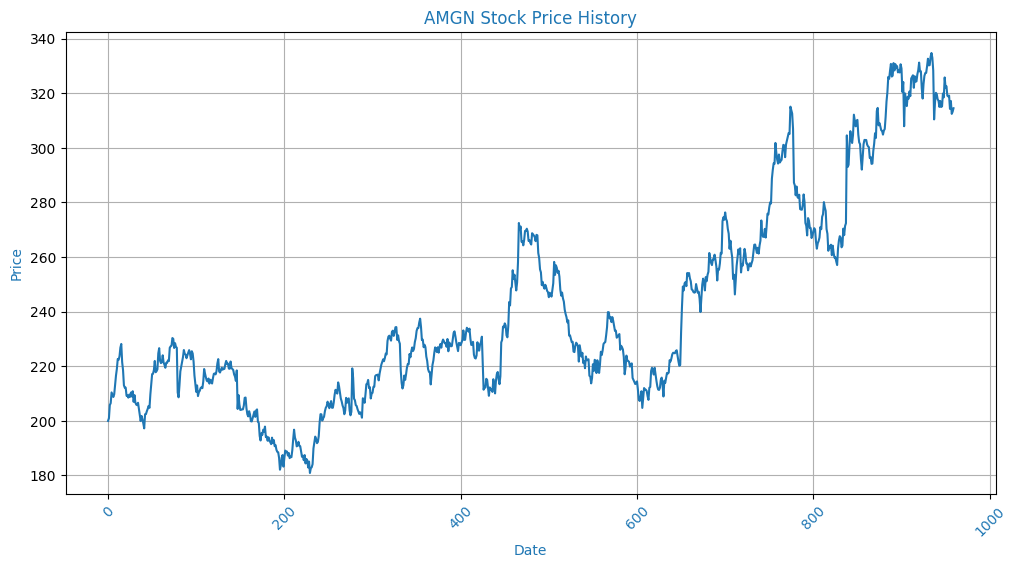

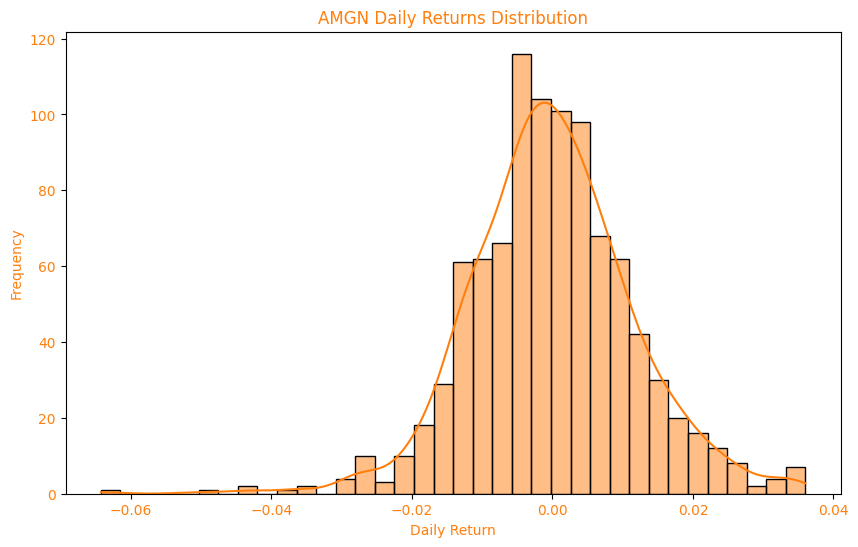


Analysis for AVGO:
--------------------------------------------------

Summary Statistics:
+-------+-------------------------------+----------+----------+----------+----------+---------------+--------------+----------------+----------------+
|       | Date                          |     Open |     High |      Low |    Close |        Volume |    Dividends |   Stock Splits |   Daily_Return |
|-------+-------------------------------+----------+----------+----------+----------+---------------+--------------+----------------+----------------|
| count | 960                           | 960      | 960      | 960      | 960      | 960           | 960          |    960         |  960           |
| mean  | 2022-11-29 13:08:59.999999744 |  76.2162 |  77.2969 |  75.1017 |  76.2381 |   2.46384e+07 |   0.00694271 |      0.0104167 |    0.000404487 |
| min   | 2021-01-04 00:00:00           |  38.4245 |  38.9773 |  38.0578 |  38.2384 |   5.952e+06   |   0          |      0         |   -0.0842618   |
| 

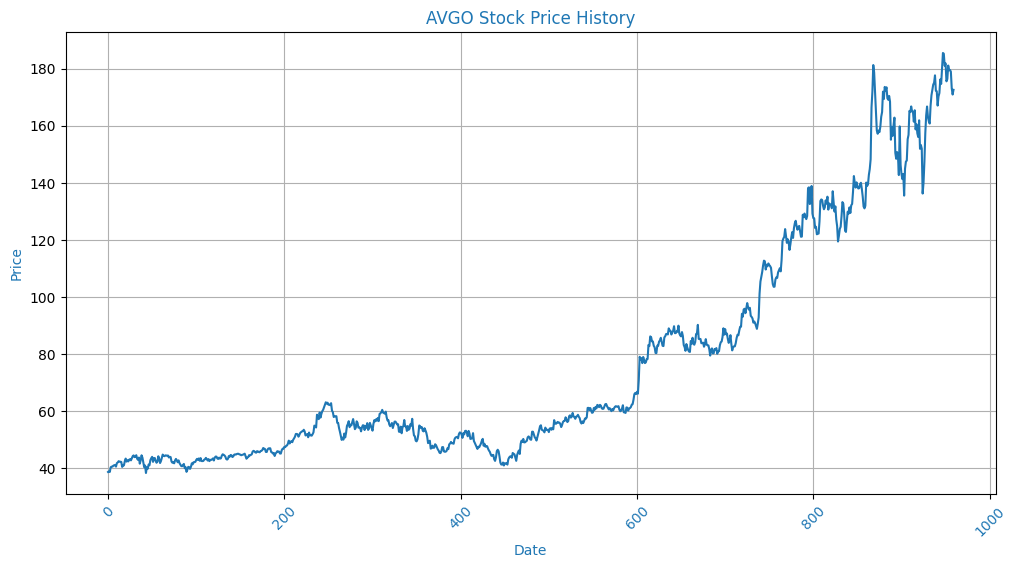

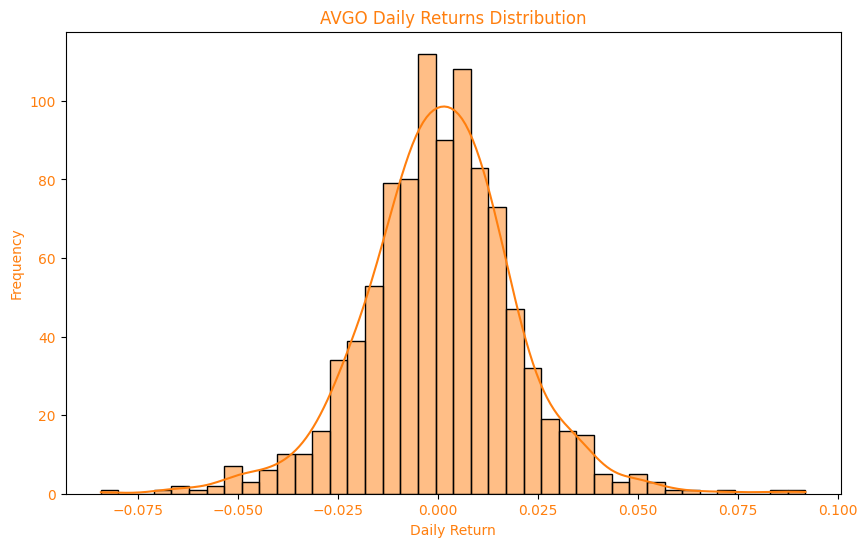


Analysis for DLTR:
--------------------------------------------------

Summary Statistics:
+-------+-------------------------------+----------+----------+----------+----------+------------------+-------------+----------------+----------------+
|       | Date                          |     Open |     High |      Low |    Close |           Volume |   Dividends |   Stock Splits |   Daily_Return |
|-------+-------------------------------+----------+----------+----------+----------+------------------+-------------+----------------+----------------|
| count | 960                           | 960      | 960      | 960      | 960      |    960           |         960 |            960 |  960           |
| mean  | 2022-11-29 13:08:59.999999744 | 127.314  | 128.909  | 125.737  | 127.338  |      2.65929e+06 |           0 |              0 |   -2.71592e-05 |
| min   | 2021-01-04 00:00:00           |  63.09   |  66.99   |  60.82   |  63.56   | 685700           |           0 |              0 |   -0.13

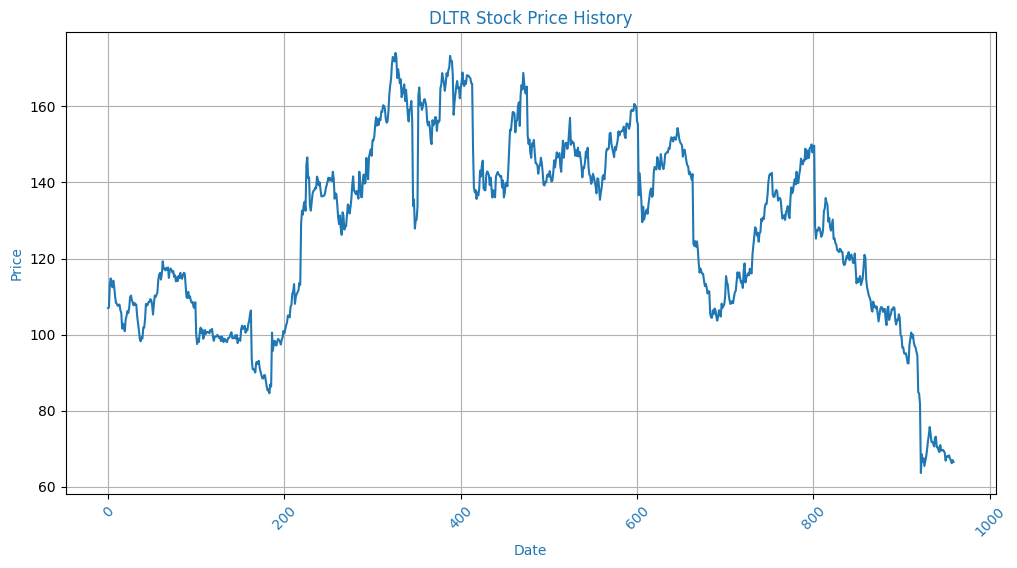

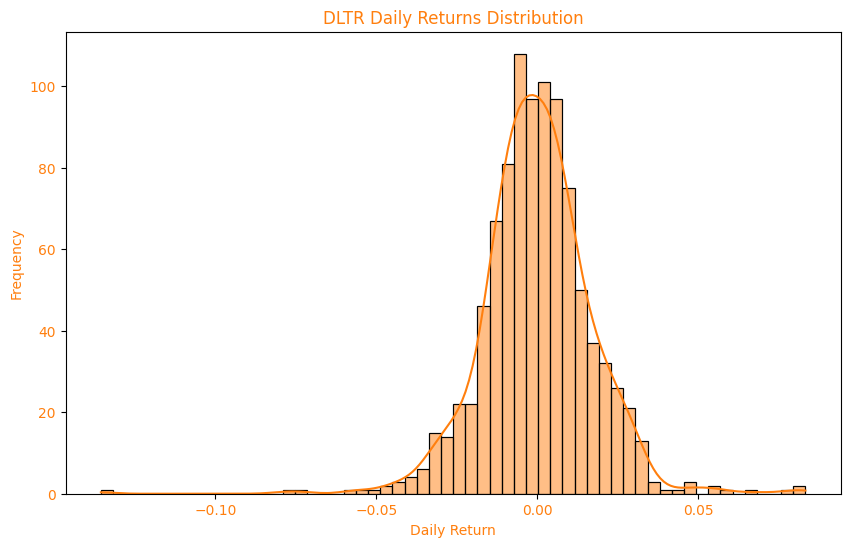


Analysis for ISRG:
--------------------------------------------------

Summary Statistics:
+-------+-------------------------------+----------+----------+----------+---------+------------------+-------------+----------------+----------------+
|       | Date                          |     Open |     High |      Low |   Close |           Volume |   Dividends |   Stock Splits |   Daily_Return |
|-------+-------------------------------+----------+----------+----------+---------+------------------+-------------+----------------+----------------|
| count | 960                           | 960      | 960      | 960      | 960     |    960           |         960 |    960         |  960           |
| mean  | 2022-11-29 13:08:59.999999744 | 310.475  | 314.038  | 306.676  | 310.495 |      1.74481e+06 |           0 |      0.003125  |    6.63819e-05 |
| min   | 2021-01-04 00:00:00           | 181.11   | 186.97   | 180.07   | 183.06  | 601300           |           0 |      0         |   -0.0859937 

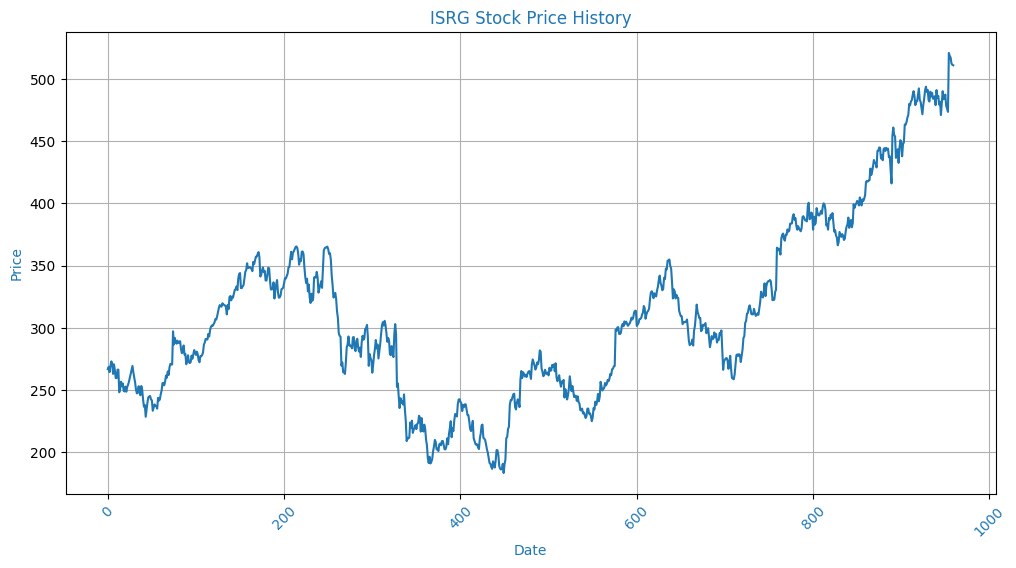

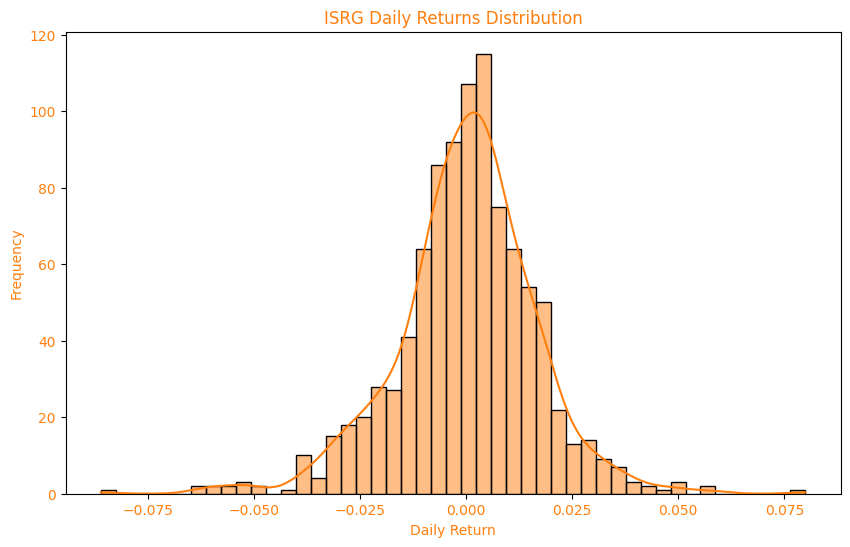


Analysis for LULU:
--------------------------------------------------

Summary Statistics:
+-------+-------------------------------+----------+----------+----------+----------+------------------+-------------+----------------+----------------+
|       | Date                          |     Open |     High |      Low |    Close |           Volume |   Dividends |   Stock Splits |   Daily_Return |
|-------+-------------------------------+----------+----------+----------+----------+------------------+-------------+----------------+----------------|
| count | 960                           | 960      | 960      | 960      | 960      |    960           |         960 |            960 |  960           |
| mean  | 2022-11-29 13:08:59.999999744 | 353.972  | 358.551  | 348.914  | 353.735  |      1.61078e+06 |           0 |              0 |   -0.000684617 |
| min   | 2021-01-04 00:00:00           | 228.08   | 236.35   | 226.01   | 233.4    | 397400           |           0 |              0 |   -0.08

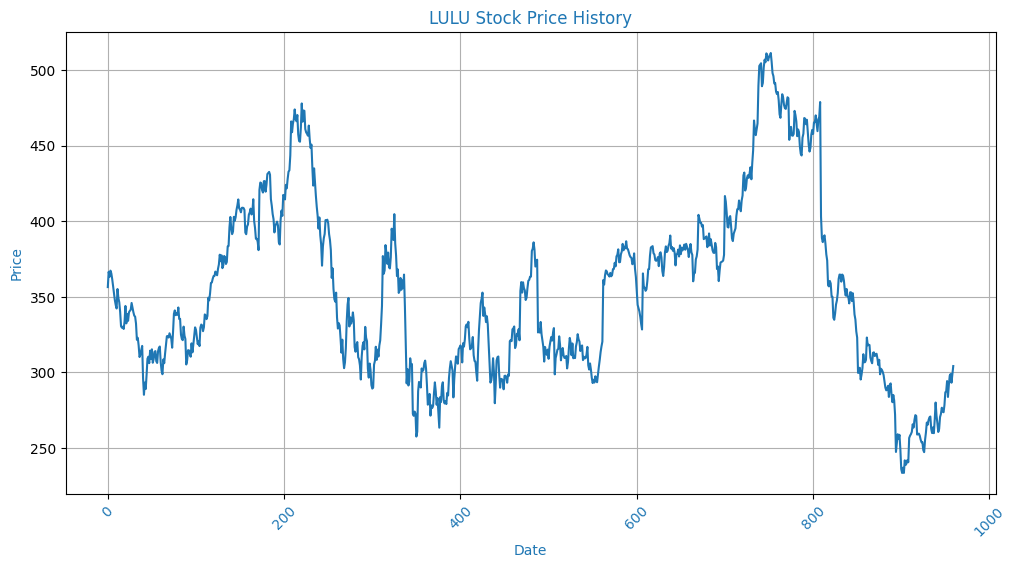

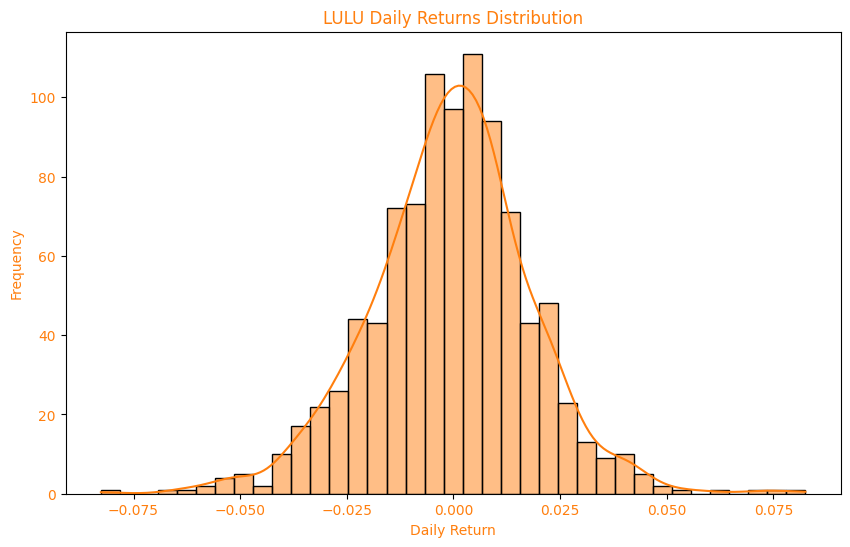


Analysis for QCOM:
--------------------------------------------------

Summary Statistics:
+-------+-------------------------------+----------+----------+----------+----------+---------------+-------------+----------------+----------------+
|       | Date                          |     Open |     High |      Low |    Close |        Volume |   Dividends |   Stock Splits |   Daily_Return |
|-------+-------------------------------+----------+----------+----------+----------+---------------+-------------+----------------+----------------|
| count | 960                           | 960      | 960      | 960      | 960      | 960           | 960         |            960 |  960           |
| mean  | 2022-11-29 13:08:59.999999744 | 136.804  | 138.676  | 134.8    | 136.768  |   8.93573e+06 |   0.0117396 |              0 |   -0.000179409 |
| min   | 2021-01-04 00:00:00           |  97.9485 |  99.1113 |  96.7371 |  98.5877 |   2.662e+06   |   0         |              0 |   -0.078268    |
| 25%   

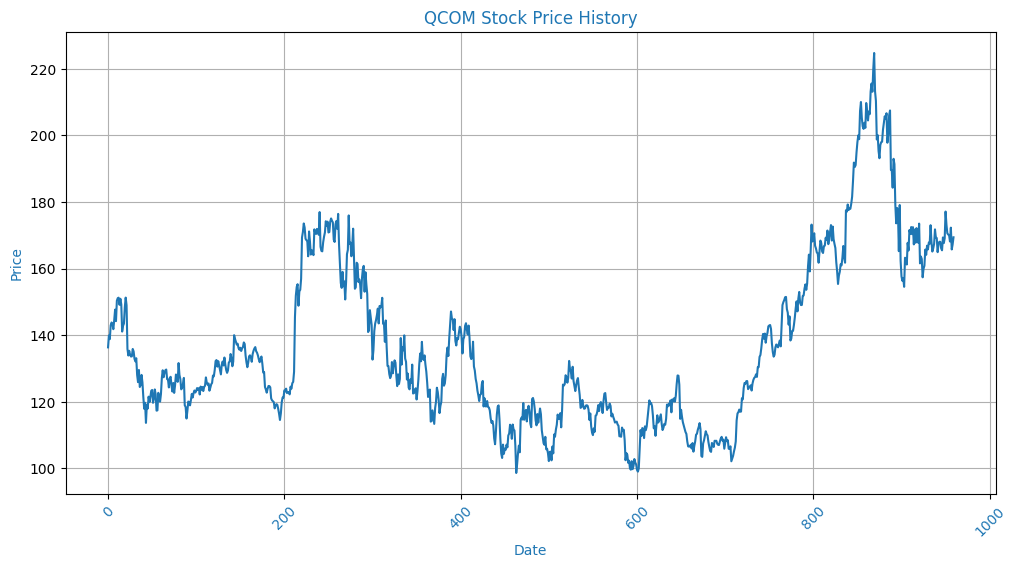

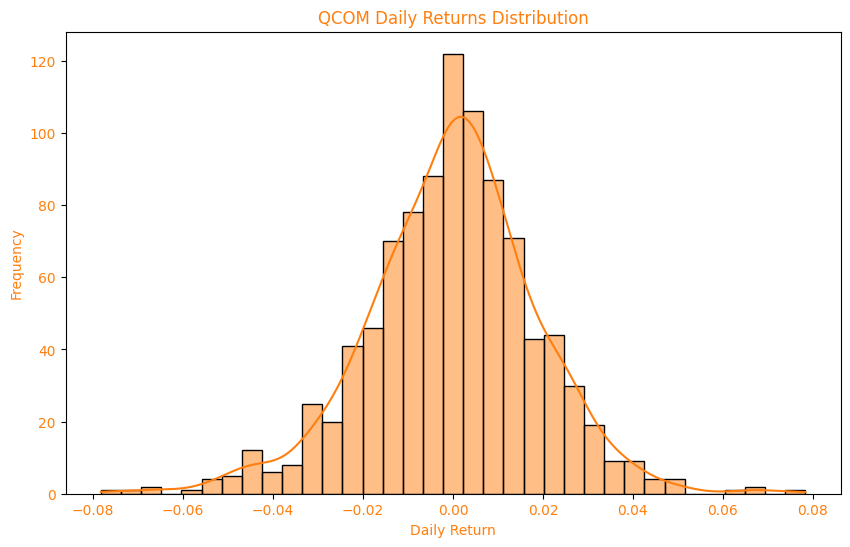


Analysis for TXN:
--------------------------------------------------

Summary Statistics:
+-------+-------------------------------+----------+---------+----------+----------+---------------+-------------+----------------+----------------+
|       | Date                          |     Open |    High |      Low |    Close |        Volume |   Dividends |   Stock Splits |   Daily_Return |
|-------+-------------------------------+----------+---------+----------+----------+---------------+-------------+----------------+----------------|
| count | 960                           | 960      | 960     | 960      | 960      | 960           | 960         |            960 |  960           |
| mean  | 2022-11-29 13:08:59.999999744 | 167.156  | 168.889 | 165.267  | 167.147  |   5.18338e+06 |   0.0185625 |              0 |   -2.55494e-05 |
| min   | 2021-01-04 00:00:00           | 135.403  | 137.493 | 134.223  | 136.608  |   1.5864e+06  |   0         |              0 |   -0.0535006   |
| 25%   | 2021-

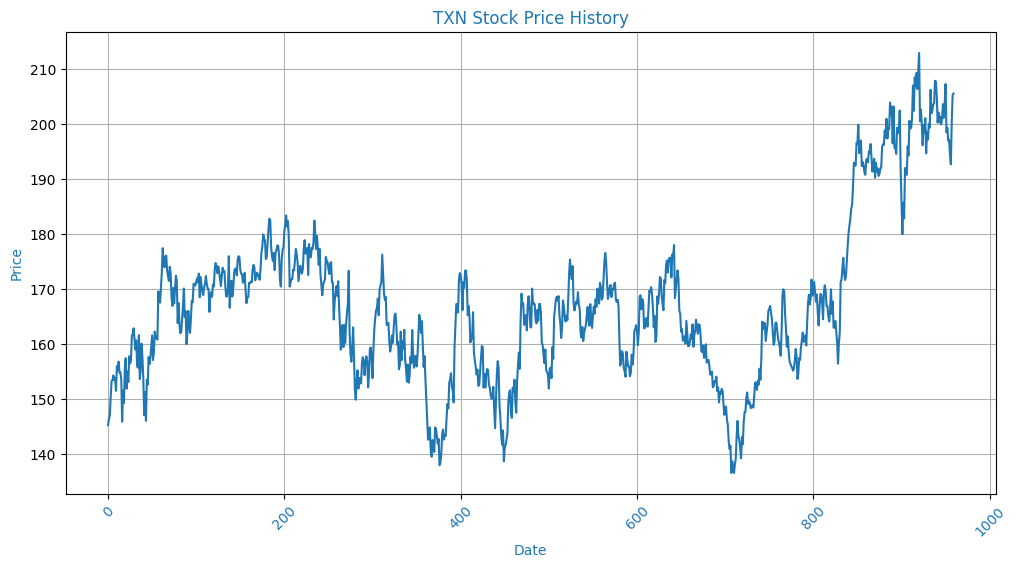

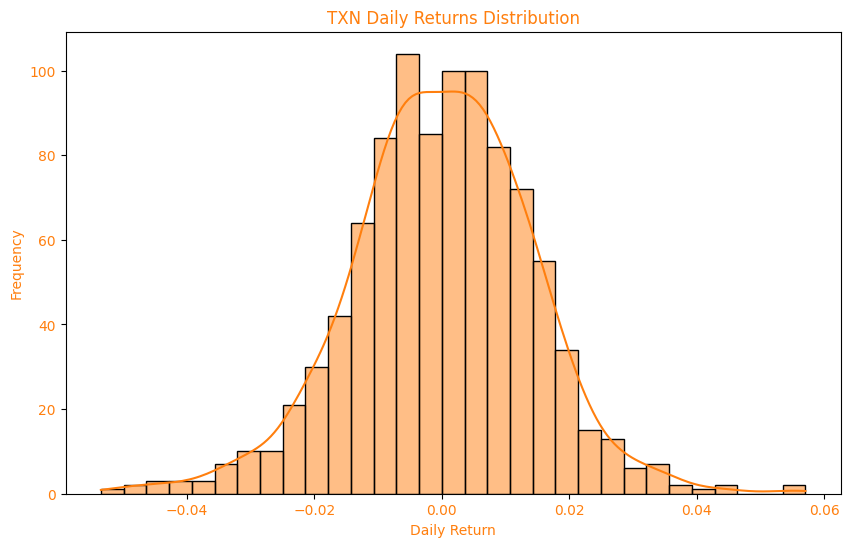

In [252]:
explore_data(all_data)

In [202]:
def plot_stock_data_comparisons(stock_data):
    """
    Plot multiple aspects of stock data for all tickers in the dictionary.
    
    Parameters:
    stock_data (dict): Dictionary with stock tickers as keys and pandas DataFrames as values
    """
    fig, axes = plt.subplots(5, 1, figsize=(14, 20), sharex=True)

    # Plot Open Prices
    for ticker, df in stock_data.items():
        axes[0].plot(df.index, df['Open'], label=ticker)
    axes[0].set_title('Open Prices for All Stocks', fontsize=14)
    axes[0].set_ylabel('Price')
    axes[0].legend(loc='best', fontsize=10)
    axes[0].grid(True)
    
    # Plot Volumes
    for ticker, df in stock_data.items():
        axes[1].plot(df.index, df['Volume'], label=ticker)
    axes[1].set_title('Volumes for All Stocks', fontsize=14)
    axes[1].set_ylabel('Volume')
    axes[1].legend(loc='best', fontsize=10)
    axes[1].grid(True)

    # Plot Low-High Range (Confidence Interval)
    for ticker, df in stock_data.items():
        axes[2].fill_between(df.index, df['Low'], df['High'], alpha=0.3, label=ticker)
    axes[2].set_title('Low-High Range for All Stocks', fontsize=14)
    axes[2].set_ylabel('Price Range')
    axes[2].legend(loc='best', fontsize=10)
    axes[2].grid(True)

    # Plot Dividends
    for ticker, df in stock_data.items():
        axes[3].plot(df.index, df['Dividends'], label=ticker)
    axes[3].set_title('Dividends for All Stocks', fontsize=14)
    axes[3].set_ylabel('Dividends')
    axes[3].legend(loc='best', fontsize=10)
    axes[3].grid(True)

    # Plot Daily Returns
    for ticker, df in stock_data.items():
        axes[4].plot(df.index, df['Daily_Return'], label=ticker)
    axes[4].set_title('Daily Returns for All Stocks', fontsize=14)
    axes[4].set_ylabel('Daily Return')
    axes[4].legend(loc='best', fontsize=10)
    axes[4].grid(True)

    # Adjust layout and show plot
    plt.xlabel('Date', fontsize=12)
    plt.tight_layout()
    plt.show()


We also deployed script for combined plots that revelead some interesting insights.

In case of price movements in the first figure, **LULU** and **ISRG** show correlated movements until  Q2 2023, when **ISRG** broke away with stronger upward momentum, likely due to healthcare sector recovery. 
Furthemore, a group of four stocks (**GOOGL**, **AVGO**, **QCOM**, **TXN**) demonstrate similar price patterns, reflecting their shared exposure to tech sector dynamics. **DLTR** also showcase similar trend to previously mentioned group up until the 2024, where it takes noticable downturn.

Moving on **LULU** experienced two notable downturns:
 1. Q1 2022, caused possibly by post-pandemic consumer behavior shift
 2. Q3-Q4 2022 probably happened because of  retail sector weakness and inventory challenges [Source](https://www.reuters.com/business/retail-consumer/lululemon-faces-sluggish-sales-upstart-brands-nip-its-heels-2024-12-04/?utm_source=chatgpt.com)

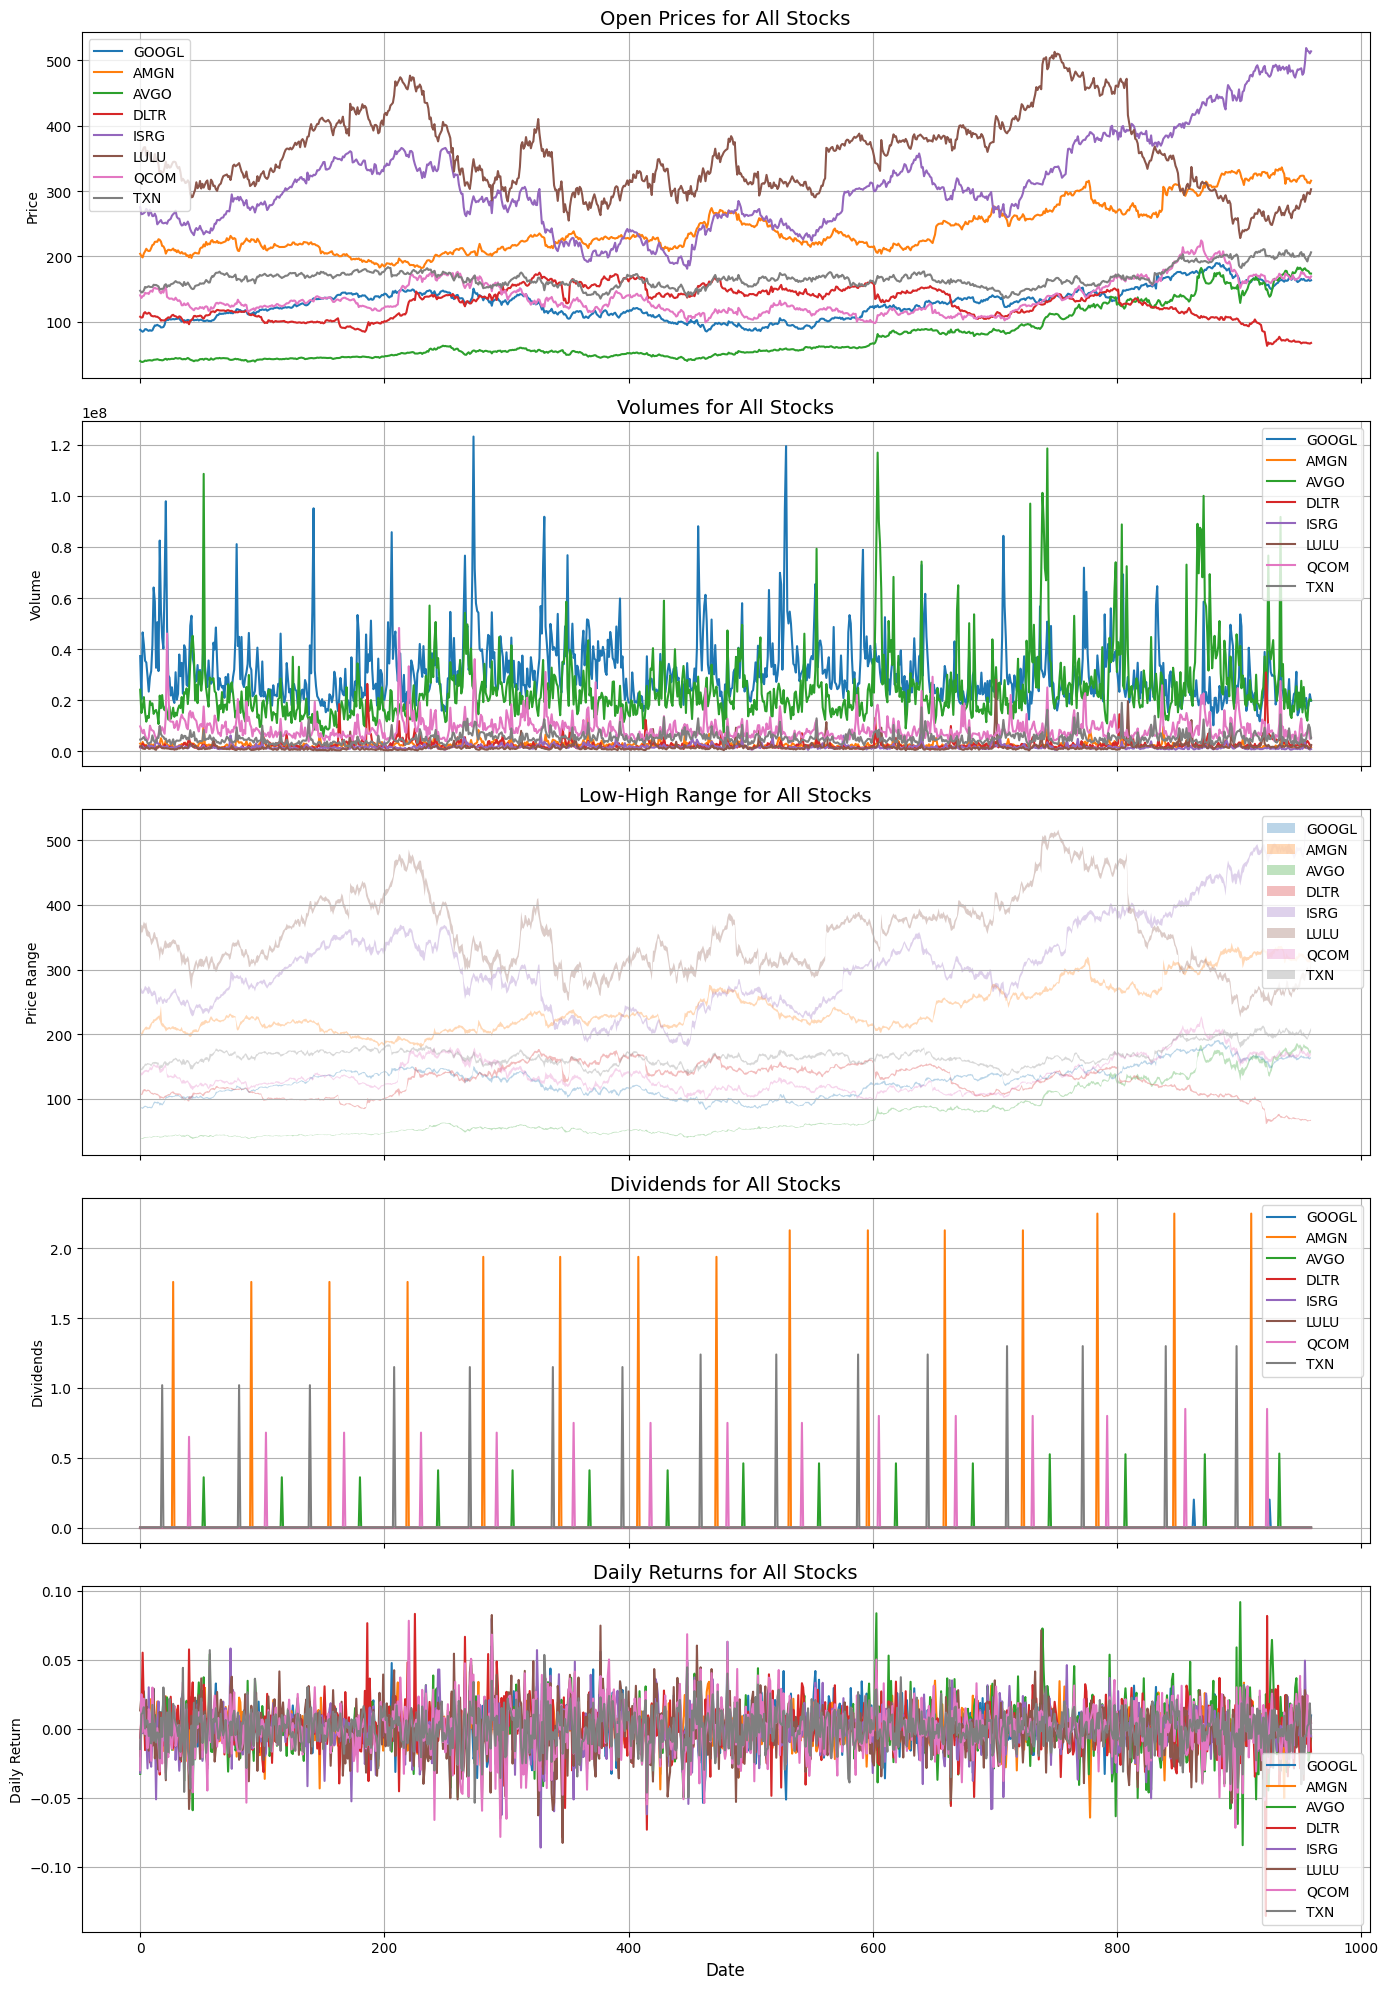

In [203]:
plot_stock_data_comparisons(all_data)

# 2. Efficient Portfolios Analysis

In this section, we analyze and estimate the set of efficient portfolios using historical data up to October 24, 2022 (end of business day). We will construct the efficient frontier without the risk-free rate ($r_f$), and subsequently calculate and plot both the Capital Market Line (CML) and Security Market Line (SML).

## 2.1. Efficient Frontier Estimation

We begin by computing the efficient frontier using our historical dataset. The process involves estimating two key parameters for each stock $i$:

- Expected returns ($\mu_i$)
- Variance-covariance matrix ($\Sigma$)

For portfolio calculations, we use the following formulas:

Portfolio expected return:
$$\mu_p = \sum_{i=1}^{n} w_i\mu_i \cdot \sqrt{252}$$
Portfolio standard deviation:
$$\sigma_p = \sqrt{w^T\Sigma w \cdot 252}$$

where:

- $w_i$ represents the weight of asset $i$
- $n$ is the number of trading days in one period (252)
- $\sum_{i=1}^{n} w_i = 1$ (weight property)
- $w_i \geq 0$ (no short-selling constraint)

To visualize the possible portfolio set, we simulate 100,000 portfolios with randomly generated weights (normalized to sum to 1). The resulting scatter plot in the mean-std plane ($\mu$-$\sigma$) reveals a characteristic cloud of feasible portfolios. The upper boundary of this cloud forms the efficient frontier, representing portfolios that offer the highest expected return for a given level of risk.


Focusing on the plot, we can notice that the characteristic parabolic shape of the portfolio cloud is present and thus aligns with modern portfolio theory. Also approximately half of the simulated portfolios exhibit negative expected returns, which is consistent with our exploratory analysis findings. The efficient frontier should trace the south-west to west part of the cloud. 

In [204]:
combined_returns_cleaned.index = pd.to_datetime(combined_returns_cleaned.index)
risk_free_rate_cleaned.index = pd.to_datetime(risk_free_rate_cleaned.index)
start_date = '2021-01-01'
end_date = '2022-10-24'

# Filter the data by date range using the index
combined_returns_subset = combined_returns_cleaned[(combined_returns_cleaned.index >= start_date) & 
                                  (combined_returns_cleaned.index <= end_date)]
risk_free_subset = risk_free_rate_cleaned[(risk_free_rate_cleaned.index >= start_date) & 
                                  (risk_free_rate_cleaned.index <= end_date)]

In [93]:
#risk_free_subset

In [205]:
expected_returns = combined_returns_subset.mean()
covariance_matrix = combined_returns_subset.cov()
risk_free_rate_one = risk_free_subset['Daily_Risk_Free_Rate'].mean()

In [206]:
def portfolio_stats(weights, expected_returns, covariance_matrix, timeAnnual):
    """
    Calculate portfolio return and portfolio standard deviation.
    """
    # Annualized return
    portfolio_return = np.sum(weights * expected_returns) * timeAnnual 
    # Annualized standard deviation
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights))) * np.sqrt(timeAnnual)
    return portfolio_return, portfolio_stddev

#Correct, port returns, std

In [207]:
# Simulate random portfolios
num_portfolios = 100000
timeAnnual = 252  # Trading year
num_assets = len(expected_returns)
results = np.zeros((3, num_portfolios))  # Rows: return, risk (std dev), Sharpe ratio

In [208]:
# Simulate random portfolios
results = np.zeros((3, num_portfolios))
for i in range(num_portfolios):
    weights = np.random.dirichlet(np.ones(num_assets))
    weights /= np.sum(weights)
    portfolio_return, portfolio_stddev = portfolio_stats(weights, expected_returns, covariance_matrix, timeAnnual)
    results[0, i] = portfolio_return
    results[1, i] = portfolio_stddev
    results[2, i] = (portfolio_return - risk_free_rate_one) / portfolio_stddev
    #print(results)

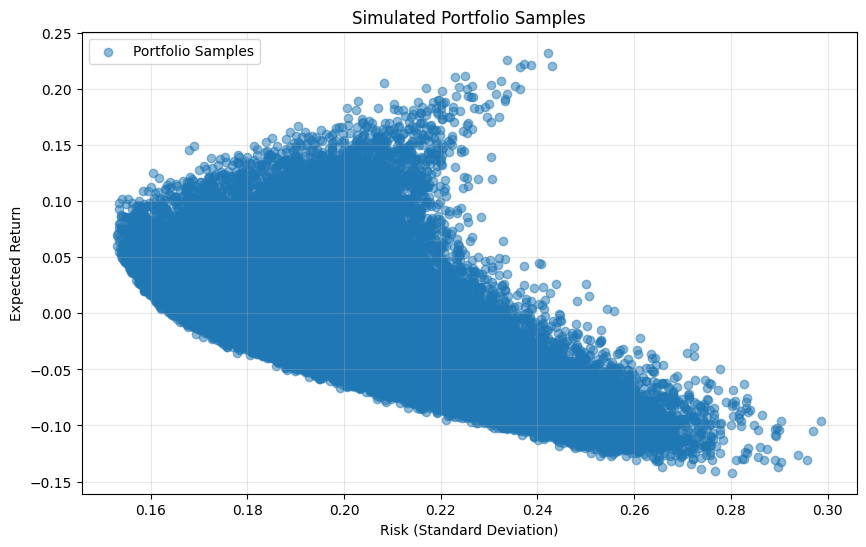

In [209]:

# Create the plot
plt.figure(figsize=(10, 6))

# Plot random portfolios
scatter = plt.scatter(results[1, :], results[0, :], 
                     alpha=0.5, 
                     label='Portfolio Samples')


plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Simulated Portfolio Samples')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()



## 2.2. Efficient Frontier and Capital Market Line


First, we subsetted the risk-free rate $r_f$ and combined returns $Y$ for given period and determined the minimum variance portfolio by minimizing the portfolio variance ($\sigma_p^2 = w^T\Sigma w$), subject to constraints that portfolio weights must sum to one ($\sum_{i=1}^n w_i = 1$). This provides us with the lowest possible risk portfolio space of feasible choices.

For clarity we opted for plotting under condition of short-selling is not allowed ($w_i \geq 0$). In the numerical comparison we allowed short-selling ($w_i \in R $).
 

For each portfolio along our frontier, we compute the Sharpe ratio ($sr = \frac{\mu_p - r_f}{\sigma_p}$), which measures the risk-adjusted excess return. This ratio serves as a key metric in identifying the optimal risk-return trade-off and helps us locate the tangency portfolio. The efficient frontier itself is constructed through an iterative optimization process, where we minimize portfolio risk for a series of target returns while maintaining our investment constraints.

The Capital Market Line (CML) emerges from this analysis, represented by the equation $\sigma_t (\mu_{CML} - r_f) =(\mu_t - r_f)\sigma_p$. Here $\mu_t$ and $\sigma_t$ correspond to the return and risk of the tangency portfolio, respectively. This portfolio, which maximizes the Sharpe ratio, represents the optimal risk portfolio when combined with the risk-free asset. Our computational approach  identifies this point by iterating through expected returns ranging from the minimum to maximum annual returns in our dataset, mapping out the complete efficient frontier and identifying the tangency point.

In [210]:
def get_min_variance_portfolio(expected_returns, covariance_matrix, num_assets, risk_free_rate):
    """
    Calculate the minimum variance portfolio, considering risk-free rate.
    """
    # Assuming risk-free rate is given or calculated separately
    risk_free_adjusted_returns = expected_returns - risk_free_rate_one

    constraints = ({"type": "eq", "fun": lambda w: np.sum(w) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    result = minimize(
        fun=lambda w: portfolio_stats(w, risk_free_adjusted_returns, covariance_matrix, timeAnnual)[1],
        x0=num_assets * [1.0 / num_assets],
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )
    
    return result.x

In [211]:
def minimize_volatility(target_return, expected_returns, covariance_matrix, num_assets, timeAnnual, short):
    """
    Minimize portfolio volatility for a given target return.
    """    
    constraints = (
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},  # Weights sum to 1
        {"type": "eq", "fun": lambda w: np.sum(w * expected_returns) * timeAnnual - target_return}  # Target return
    )    
    if short:
        bounds = tuple((-1, 1) for _ in range(num_assets))
    else:
        bounds = tuple((0, 1) for _ in range(num_assets)) 
        
    result = minimize(
        fun=lambda w: portfolio_stats(w, expected_returns, covariance_matrix, timeAnnual)[1],
        x0=num_assets * [1.0 / num_assets],
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )
    
    if not result.success:
        raise ValueError("Optimization failed: " + result.message)
    
    return result.x

In [212]:
# Find the maximum Sharpe ratio portfolio
max_sharpe_idx = np.argmax(results[2,:])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_stddev = results[1, max_sharpe_idx]

In [213]:
short = False

In [214]:
# Generate efficient frontier points
target_returns = np.linspace(expected_returns.min()*252, expected_returns.max()*252, 100)
frontier_returns = []
frontier_risks = []

for target_return in target_returns:
    weights = minimize_volatility(target_return, expected_returns, covariance_matrix, num_assets,timeAnnual,short)
    ret, risk = portfolio_stats(weights, expected_returns, covariance_matrix, timeAnnual)
    frontier_returns.append(ret)
    frontier_risks.append(risk)

# Calculate Capital Market Line
max_sharpe_index = np.argmax([ (ret - risk_free_rate_one*timeAnnual) / risk for ret, risk in zip(frontier_returns, frontier_risks)])

tangency_return = frontier_returns[max_sharpe_index]
tangency_risk = frontier_risks[max_sharpe_index]

# Slope of the Capital Market Line (CML)
slope_cml = (tangency_return - risk_free_rate_one*timeAnnual) / tangency_risk

# Calculate x_cml and y_cml (Capital Market Line)
x_cml = np.linspace(0, max(frontier_risks), 100)
y_cml = risk_free_rate_one*timeAnnual + slope_cml * x_cml




In [215]:
short = True

In [217]:
# Calculate tangency portfolio
def get_tangency_portfolio(expected_returns, covariance_matrix, risk_free_rate, num_assets, timeAnnual, shorts = False):
    """
    Calculate the tangency portfolio weights
    """
    constraints = ({"type": "eq", "fun": lambda w: np.sum(w) - 1})
    if shorts:
        bounds = tuple((-1, 1) for _ in range(num_assets))
    else:
        bounds = tuple((0, 1) for _ in range(num_assets)) 
    
    # Define Sharpe ratio to maximize
    def negative_sharpe_ratio(weights):
        portfolio_ret, portfolio_std = portfolio_stats(weights, expected_returns, covariance_matrix, timeAnnual)
        sharpe = (portfolio_ret - risk_free_rate*timeAnnual) / portfolio_std
        return -sharpe  # Negative because we want to maximize
    
    result = minimize(
        fun=negative_sharpe_ratio,
        x0=num_assets * [1.0 / num_assets],
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    
    return result.x


In [230]:
# Get tangency portfolio weights and stats
tangency_weights = get_tangency_portfolio(expected_returns, covariance_matrix, risk_free_rate_one, num_assets, timeAnnual)
tangency_return, tangency_risk = portfolio_stats(tangency_weights, expected_returns, covariance_matrix, timeAnnual)
tangency_weights_s =  get_tangency_portfolio(expected_returns, covariance_matrix, risk_free_rate_one, num_assets, timeAnnual, short)
tangency_return_s, tangency_risk_s = portfolio_stats(tangency_weights_s, expected_returns, covariance_matrix, timeAnnual)

In the figure below, we have presented the Efficient Frontier (EF) together with the Capital Market Line (CML), which confirms our earlier analysis of the portfolio distribution. The efficient frontier, depicted as the solid blue line, traces the upper boundary of our simulated portfolio cloud. It represents the set of portfolios that offer the optimal risk-return tradeoff in the absence of a risk-free asset. This alignment with our preliminary analysis serves to validate the computational approach employed.

The plot reveals several key insights regarding our investment space:

- **Minimum Variance Portfolio** (orange circle): This portfolio represents the lowest achievable risk through diversification.
- **Tangency Portfolio** (green triangle): This marks the optimal point where the CML intersects the efficient frontier.
- **Capital Market Line** (red dashed line): Extending from the risk-free rate, the CML represents new investment opportunities created by combining the risk-free asset with the tangency portfolio.

Individual stocks, marked by black X's, generally lie below the efficient frontier, emphasizing the benefits of diversification. Portfolios on the efficient frontier consistently offer better expected returns for given levels of risk compared to individual stocks. The color gradient of the portfolio cloud, representing Sharpe ratios, further enhances the analysis. Brighter colors indicate superior risk-adjusted returns, providing additional insight into the performance of various portfolio combinations.

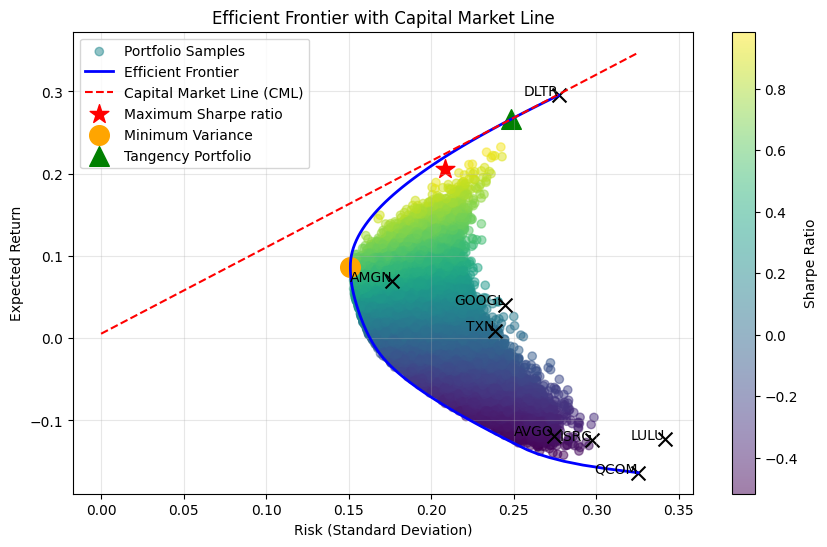

In [268]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot random portfolios
scatter = plt.scatter(results[1, :], results[0, :], 
                     c=results[2, :], 
                     cmap='viridis', 
                     alpha=0.5, 
                     label='Portfolio Samples')

# Plot efficient frontier
plt.plot(frontier_risks, frontier_returns, 
         color='blue', 
         linewidth=2, 
         label='Efficient Frontier')

# Plot CML
plt.plot(x_cml, y_cml, 
         color='red', 
         linestyle='--', 
         label='Capital Market Line (CML)')

# Plot maximum Sharpe ratio point
plt.scatter(max_sharpe_stddev, max_sharpe_return, 
           color='red', 
           marker='*', 
           s=200, 
           label='Maximum Sharpe ratio')

# Plot minimum variance point
plt.scatter(min_var_risk, min_var_return, 
           color='orange', 
           marker='o', 
           s=200, 
           label='Minimum Variance')

# Plot tangency portfolio
plt.scatter(tangency_risk, tangency_return, 
           color='green', 
           marker='^', 
           s=200, 
           label='Tangency Portfolio')

# Plot individual assets (stocks) with tickers
for i, ticker in enumerate(stock_files.keys()):
    plt.scatter(np.sqrt(covariance_matrix.iloc[i, i]) * np.sqrt(timeAnnual),  
                expected_returns.iloc[i] * timeAnnual,  # Changed from [i] to .iloc[i]
                color='black', 
                marker='x', 
                s=100)
    plt.annotate(ticker, 
                 (np.sqrt(covariance_matrix.iloc[i, i]) * np.sqrt(timeAnnual),  
                  expected_returns.iloc[i] * timeAnnual),  # Changed from [i] to .iloc[i]
                 fontsize=10, 
                 ha='right', 
                 color='black')

plt.colorbar(scatter, label='Sharpe Ratio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Capital Market Line')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

In the table below, we observe that our **tangency portfolio without short selling** is composed of only two stocks: **AMGN (13%)** and **DLTR (87%)**. This portfolio maximizes returns during this time period but is highly volatile due to the heavy concentration in **DLTR** stock. This concentration introduces significant risk, as any large fluctuation in **DLTR** can dramatically impact the portfolio's performance. We will discuss this further in the final section.

When **short selling is allowed**, the portfolio shows much more diversification, with positions in 4 long assets and 4 short positions, which significantly spreads the risk across multiple assets. Short selling enables the portfolio to benefit from both upward and downward price movements, allowing for a more flexible approach to managing risk. The **long positions** in stocks like **GOOGL (87.14%)** and **TXN (95.46%)** reflect a belief in their continued growth, while the **short positions** in stocks like **AVGO (-68.66%)**, **ISRG (-38.28%)**, **LULU (-33.56%)**, and **QCOM (-68.31%)** reflect the portfolio's strategy to hedge against potential downturns or overvaluation in these stocks.namics.



In [272]:
# Table 2: Weights for No Short Selling vs. Short Selling
tangency_weights_df = pd.DataFrame({
    "Ticker": tickers,
    "No Short Selling": tangency_weights,
    "With Short Selling": tangency_weights_s
})

print("\nTangency Portfolio Weights:")
print(tabulate(tangency_weights_df, headers="keys", tablefmt="psql", floatfmt=".4f"))



Tangency Portfolio Weights:
+----+----------+--------------------+----------------------+
|    | Ticker   |   No Short Selling |   With Short Selling |
|----+----------+--------------------+----------------------|
|  0 | GOOGL    |             0.0000 |               0.8714 |
|  1 | AMGN     |             0.1299 |               0.2621 |
|  2 | AVGO     |             0.0000 |              -0.6866 |
|  3 | DLTR     |             0.8701 |               1.0000 |
|  4 | ISRG     |             0.0000 |              -0.3828 |
|  5 | LULU     |             0.0000 |              -0.3356 |
|  6 | QCOM     |             0.0000 |              -0.6831 |
|  7 | TXN      |             0.0000 |               0.9546 |
+----+----------+--------------------+----------------------+


In [273]:
# Table 1: Tangency Portfolio Return & Risk (No Short Selling vs. With Short Selling)
tangency_metrics = pd.DataFrame({
    "Metric": ["Return", "Risk"],
    "No Short Selling": [tangency_return, tangency_risk],
    "With Short Selling": [tangency_return_s, tangency_risk_s]
})

print("\nTangency Portfolio Details:")
print(tabulate(tangency_metrics, headers="keys", tablefmt="psql", floatfmt=".4f"))



Tangency Portfolio Details:
+----+----------+--------------------+----------------------+
|    | Metric   |   No Short Selling |   With Short Selling |
|----+----------+--------------------+----------------------|
|  0 | Return   |             0.2660 |               0.6392 |
|  1 | Risk     |             0.2482 |               0.3689 |
+----+----------+--------------------+----------------------+


In the table above, we can assess the impact of allowing short selling on the tangency portfolio. While the **portfolio with short selling** shows a **10% higher risk** compared to the **no short selling** portfolio, it more than **doubles the return** (63 % vs 27 %). This indicates that the short-selling strategy offers a significantly higher return for a reasonable increase in risk.

For an investor with a **reasonable level of risk-aversion**, the portfolio with short selling may be a more attractive choice. The increased risk is offset by the higher returns, and the diversification benefits from the short positions can help manage the overall portfolio risk. Therefore, investors willing to tolerate a bit more volatility in exchange for potentially higher returns might find the portfolio with short selling to be a more optimal option.

## 2.3. Security Market Line



The **Security Market Line (SML)** represents the theoretical relationship between the **systematic risk (beta)** and the **expected return** of individual securities in equilibrium, as postulated by the **Capital Asset Pricing Model (CAPM)**. According to CAPM, the expected return of an asset depends on its exposure to systematic risk, represented by its **beta (β)**. Beta is a measure of an asset’s sensitivity to overall market movements, with higher betas indicating greater sensitivity to market fluctuations.return, assumingd expect from a given level of systematic risk.



Mathematically, the relationship between an asset's expected return and the return of the **tangency portfolio** can be described as $\mu_k - \mu_0 = \frac{\sigma_{k,T}}{\sigma_T^2} (\mu_T - \mu_0), \quad k = 1, \dots, K$.

where:
- $\mu_k$ is the expected return of asset $k$,
- $\mu_0$ is the risk-free rate,
- $\mu_T$ is the expected return of the tangency portfolio,
- $\sigma_{k,T}$ is the covariance between the returns of asset $k$ and the tangency portfolio,
- $\sigma_T^2$ is the variance of the tangency portfolio’s returns.

Rewriting this equation in terms of beta $\beta_k = \frac{\sigma_{k,T}}{\sigma_T^2}$. We estimated $\beta_k$ using theory from practicals.

This ratio, $\beta_k$, represents the asset's **beta**, which measures the asset's **systematic risk** in relation to the tangency portfolio. The **SML** illustrates how the expected return of individual assets is related to their systematic risk. The higher the beta, the higher the expected return, assuming a linear relationship.

### 2.3.1 Interpretation of SML

In our graph, the **Security Market Line (SML)** is represented by the blue line, which starts at the risk-free rate and slopes upward. The line illustrates the positive linear relationship between **beta** and **expected return**. The individual stocks in our portfolio are plotted according to their respective betas (x-axis) and expected returns (y-axis). The positioning of these stocks relative to the SML provides valuable insights:

- **DLTR** is positioned directly on the SML at **β ≈ 1.0**, implying that its expected return aligns exactly with the return predicted by CAPM for its level of systematic risk.
- **AMGN** is also positioned on the SML, but with a much **lower beta (β ≈ 0.25)**. This suggests that AMGN has significantly less systematic risk compared to other assets, and its expected return aligns with CAPM predictions for its low risk.
- **GOOGL** and **TXN** are close to the SML but slightly below it, suggesting they may be **overvalued** or offering slightly lower returns than CAPM would predict.
- **QCOM, AVGO, ISRG, and LULU** have both **low betas** and **negative expected returns**, which could indicate poor historical performance or adverse market conditions during the analysis period.
- The **beta range** spans from approximately **-0.5** to **1.0**, with most stocks clustered below **β = 0.5**, suggesting relatively low systematic risk across the portfolio.

In general, most stocks appear to be **overpriced**, as they are positioned below the SML, indicating that their expected returns do not adequately compensate for their level of risk. This underperformance suggests that, based on the CAPM model, investors might be taking on more risk than is justified by the returns.

In [91]:
timeAnnual = 252
expected_returns = combined_returns_subset.mean()
yearly_expected_returns = expected_returns*timeAnnual
covariance_matrix = combined_returns_subset.cov()
yearly_covariance_matrix = covariance_matrix*timeAnnual
risk_free_rate_one = risk_free_subset['Daily_Risk_Free_Rate'].mean()
yearly_risk_free_rate_one = risk_free_rate_one*timeAnnual
num_assests = len(expected_returns)
tickers = list(stock_files.keys())

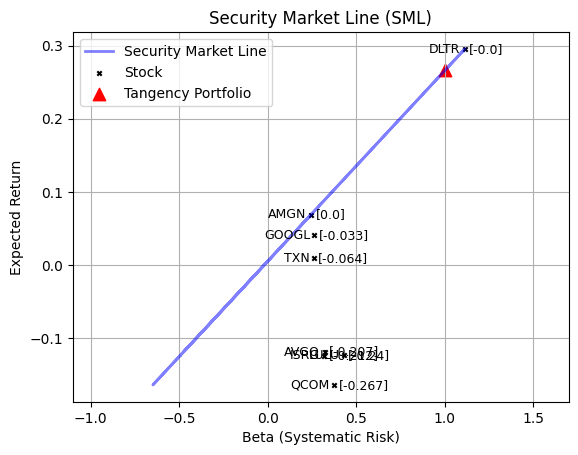

In [116]:
beta_sml = (yearly_expected_returns - yearly_risk_free_rate_one) / (tangency_return - yearly_risk_free_rate_one)
betas_sml = np.linspace(0, 2, 100)  # Beta range for the SML
sml_returns = yearly_risk_free_rate_one + betas_sml * (tangency_return - yearly_risk_free_rate_one)

daily_tangency_returns = combined_returns_subset.values @ tangency_weights
y = (combined_returns_subset.subtract(risk_free_subset['Daily_Risk_Free_Rate'],axis=0))*timeAnnual
x = (daily_tangency_returns - risk_free_subset['Daily_Risk_Free_Rate'])*timeAnnual
x = sm.add_constant(x)

alphas = []
betas = []
for ticker in tickers:
    model = sm.OLS(y[ticker].values,x).fit()
    alpha, beta = model.params
    alphas.append(alpha)
    betas.append(beta)

returns_ab = np.array(alphas) + yearly_risk_free_rate_one + np.array(betas) * (tangency_return - yearly_risk_free_rate_one)

# # Plot the SML
plt.plot(beta_sml, yearly_expected_returns, label="Security Market Line", color='blue', linewidth=2, alpha=0.5)
plt.scatter(np.array(betas), returns_ab, label='Stock', color='black', s=10, marker='x')
plt.scatter(1, tangency_return, 
          color='red', 
          marker='^', 
          s=80, 
          label='Tangency Portfolio')

for i, ticker in enumerate(tickers):
    plt.text(np.array(betas)[i]-0.025, returns_ab[i], 
             ticker, 
             fontsize=9, 
             ha='right', 
             va='center')
    a=str([np.round(alphas[i], 3)])
    plt.text(np.array(betas)[i]+0.025, returns_ab[i], 
             a,
             fontsize=9, 
             ha='left', 
             va='center')
# # Labels and title
plt.xlim(-1.1, 1.7)
plt.title("Security Market Line (SML)")
plt.xlabel("Beta (Systematic Risk)")
plt.ylabel("Expected Return")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()


# 3. Markowitz Model

### 3.1 Theoretical Background

The **Markowitz model** (Mean-Variance Optimization) aims to find the optimal portfolio that balances risk and return. The model defines the optimal portfolio weights $w$ that either maximize expected return subject to a constraint on portfolio risk or minimize portfolio risk for a given expected return. We opted for the second option, thus our optimization problem is formulated as follows:

$$
\min_w \quad \frac{1}{2} w^T \Sigma w
$$
subject to:
$$
w^T \mu + w_0 r_f \geq \bar{\mu}
$$
$$
w^T \mathbf{1} + w_0 = 1
$$

where:  
- $w$ is the vector of portfolio weights.  
- $\Sigma$ is the covariance matrix of asset returns.  
- $\mu$ is the vector of expected asset returns.  
- $r_f$ is the risk-free rate.  
- $w_0$ is the weight assigned to the risk-free asset.  
- $\bar{\mu}$ is the minimum required portfolio return.  
- $\mathbf{1}$ is a vector of ones.  



The minimum expected return  $\bar{\mu}$ of **10% p.a.** is chosen as a realistic target based on current market behavior and risk tolerance. We have chosen historical returns and variance as our estimates, since they yielded best results against other 
ones (e.g. Exponentially Weighted Moving Average).

The **expected returns**  $\hat{\mu}_i$ for each asset are estimated using historical data as the sample mean of asset returns over a chosen period:
$$
\hat{\mu}_i = \frac{1}{T} \sum_{t=1}^{T} \mu_{i,t}
$$
where $\mu_{i,t}$ represents the return of asset $i$ at time $t$, and  $T$ is the number of historical data points.

The **variance-covariance matrix** $\Sigma$ is estimated as:
$$
\hat{\Sigma}_{i,j} = \frac{1}{T-1} \sum_{t=1}^{T} (\mu_{i,t} - \hat{\mu}_i)(\mu_{j,t} - \hat{\mu}_j)
$$
where $\hat{\Sigma}_{i,j}$ represents the covariance between the returns of assets $i$ and  $j$.

In [71]:
min_returnM = 0.1
min_d_return = min_returnM/timeAnnual
shorting=True

In [148]:
def historical_mean_return_variance(date, stock_returns, risk_free_rate, year):
    target_date = pd.Timestamp(date)
    one_year_before = target_date - pd.DateOffset(years=1)
    start_date = stock_returns.index[stock_returns.index >= one_year_before][0]
    end_date = stock_returns.index[stock_returns.index < target_date][-1]
    
    stock_returns_subset = stock_returns[(stock_returns.index >= start_date) & 
                                  (stock_returns.index <= end_date)]
    risk_free_rate_subset = risk_free_rate[(risk_free_rate.index >= start_date) & 
                                  (risk_free_rate.index <= end_date)]
    
    expected_returns = stock_returns_subset.mean()
    yearly_expected_returns = expected_returns*year
    covariance_matrix = stock_returns_subset.cov()
    yearly_covariance = covariance_matrix*year
    risk_free_rate_one = risk_free_rate['Daily_Risk_Free_Rate'].mean()
    yearly_risk_free_rate_one = risk_free_rate_one*year
    num_assets = len(expected_returns)

    return yearly_expected_returns, yearly_covariance, yearly_risk_free_rate_one, num_assets

In [118]:
def ewma_return_variance(date, stock_returns, risk_free_rate, yearsTime):
    lambda_=0.94
    target_date = pd.Timestamp(date)
    one_year_before = target_date - pd.DateOffset(yearsTime=1)
    start_date = stock_returns.index[stock_returns.index >= one_year_before][0]
    end_date = stock_returns.index[stock_returns.index < target_date][-1]

    stock_returns_subset = stock_returns[(stock_returns.index >= start_date) & 
                                         (stock_returns.index <= end_date)]
    risk_free_subset = risk_free_rate[(risk_free_rate.index >= start_date) & 
                                           (risk_free_rate.index <= end_date)]
    
    n = len(stock_returns_subset)
    weights = (1 - lambda_) * lambda_ ** (n - 1 - np.arange(n))
    weights /= weights.sum()
    
    expected_returns = (weights[:, None] * stock_returns_subset).sum(axis=0)
    yearly_expected_returns = expected_returns * yearsTime

    demeaned_returns = stock_returns_subset - stock_returns_subset.mean()
    weighted_cov = np.zeros((len(stock_returns.columns), len(stock_returns.columns)))
    for i, (index, row) in enumerate(demeaned_returns.iterrows()):
        weighted_cov += weights[i] * np.outer(row, row)
    yearly_covariance = weighted_cov * yearsTime

    ewma_risk_free_rate = (weights * risk_free_subset['Daily_Risk_Free_Rate']).sum()
    yearly_risk_free_rate_one = ewma_risk_free_rate * yearsTime

    num_assets = len(expected_returns)

    return yearly_expected_returns, yearly_covariance, yearly_risk_free_rate_one, num_assets

In [119]:
def calculate_minimum_risk_portfolio(min, expected_returns, covariance, num_assets, rfr, short):
    returns = expected_returns - rfr

    initial_weights = np.ones(num_assets)/num_assets
    constraints = [
        {'type': 'ineq', 'fun': lambda w:  np.dot(w, returns) + rfr - min}
    ]
    if short: lb=-1
    else: lb=0
    bounds = [(lb, 1) for i in range(num_assets)]
    
    def portfolio_risk(w):
        return 0.5 * np.dot(w.T, np.dot(covariance, w))
    
    Mark = minimize(fun=lambda w: portfolio_risk(w), x0=initial_weights, constraints=constraints, bounds=bounds)
    
    # Portfolio weights, risk, and return
    weights = Mark.x
    rfw = 1-np.sum(weights)
    portfolio_return = np.dot(weights, expected_returns) + rfw*rfr
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(covariance, weights)))
    
    return {
        'weights': weights,
        'portfolio_return': portfolio_return,
        'portfolio_risk': portfolio_risk,
        'risk_free_weight': rfw
    }

In [100]:
Markowitz_port = calculate_minimum_risk_portfolio(min_returnM, yearly_expected_returns, yearly_covariance_matrix, num_assets, yearly_risk_free_rate_one, shorting)
Markowitz_without_s = calculate_minimum_risk_portfolio(min_returnM, yearly_expected_returns, yearly_covariance_matrix, num_assets, yearly_risk_free_rate_one, False)

In [120]:
target_returns = np.linspace(yearly_expected_returns.min(), yearly_expected_returns.max(), 100)
frontier_returns = []
frontier_risks = []

for target_return in target_returns:
    weights = minimize_volatility(target_return, expected_returns, covariance_matrix, num_assets,timeAnnual, False)
    ret, risk = portfolio_stats(weights, expected_returns, covariance_matrix, timeAnnual)
    frontier_returns.append(ret)
    frontier_risks.append(risk)

# Calculate Capital Market Line
max_sharpe_index = np.argmax([ (ret - yearly_risk_free_rate) / risk for ret, risk in zip(frontier_returns, frontier_risks)])

tangency_return = frontier_returns[max_sharpe_index]
tangency_risk = frontier_risks[max_sharpe_index]
#tangency_weights = min_volatility_weights(tangency_return, yearly_expected_returns, yearly_covariance_matrix, assets, False)

target_returns_s = np.linspace(yearly_expected_returns.min(), yearly_expected_returns.max()*1.5, 100)
frontier_returns_s = []
frontier_risks_s = []

for target_return in target_returns_s:
    weights = minimize_volatility(target_return, expected_returns, covariance_matrix, num_assets,timeAnnual, True)
    ret, risk = portfolio_stats(weights, expected_returns, covariance_matrix, timeAnnual)
    frontier_returns_s.append(ret)
    frontier_risks_s.append(risk)

# Calculate Capital Market Line
max_sharpe_index_s = np.argmax([ (ret - yearly_risk_free_rate_one) / risk for ret, risk in zip(frontier_returns_s, frontier_risks_s)])

tangency_return_s = frontier_returns_s[max_sharpe_index_s]
tangency_risk_s = frontier_risks_s[max_sharpe_index_s]
#tangency_weights_s = min_volatility_weights(tangency_return_s, yearly_expected_returns, yearly_covariance_matrix, assets, True)

## 3.2. Visualization of Markowitz Portfolio

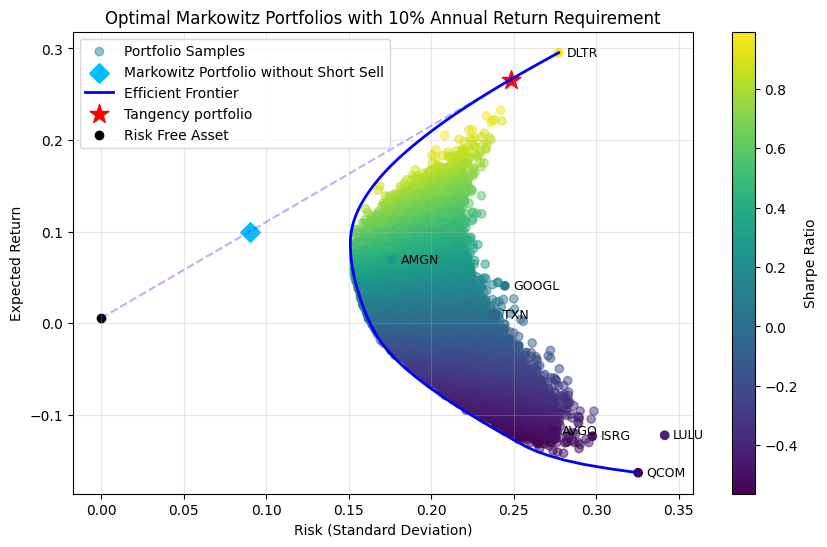

In [274]:
# Create the plot
plt.figure(figsize=(10, 6))

# Define portfolio characteristics
markowitz_risk = Markowitz_port['portfolio_risk']
markowitz_return = Markowitz_port['portfolio_return']
long_risk = Markowitz_without_s['portfolio_risk']
long_return = Markowitz_without_s['portfolio_return']

# Plot random portfolios
scatter = plt.scatter(results[1, :], results[0, :], 
                     c=results[2, :], 
                     cmap='viridis', 
                     alpha=0.5, 
                     label='Portfolio Samples')

# Plot Markowitz optimal portfolio
plt.scatter(long_risk, long_return,
           color='deepskyblue',
           marker='D',
           s=100,
           label='Markowitz Portfolio without Short Sell')

# Plot efficient frontier
plt.plot(frontier_risks, frontier_returns, 
         color='blue', 
         linewidth=2, 
         label='Efficient Frontier')

# Plot tangency portfolio
plt.scatter(tangency_risk, tangency_return, 
           color='red', 
           marker='*', 
           s=200, 
           label='Tangency portfolio')

# Plot risk-free asset
plt.scatter(0, yearly_risk_free_rate_one,
           color='black',
           label='Risk Free Asset')

# Calculate portfolio metrics
risks = np.sqrt(np.diag(yearly_covariance_matrix))
returns_exp = yearly_expected_returns.to_numpy()  # Convert to numpy array
sharpe_ratios = (returns_exp - yearly_risk_free_rate) / risks

# Plot individual assets with Sharpe ratios
scatter_assets = plt.scatter(risks, returns_exp,
                           c=sharpe_ratios, 
                           alpha=1)

# Add ticker labels
for i, ticker in enumerate(tickers):
    plt.text(risks[i] + 0.005, returns_exp[i],  # Now using numpy array
             ticker, 
             fontsize=9, 
             ha='left', 
             va='center')

# Plot CML (Capital Market Line)
plt.plot([0, tangency_risk], [yearly_risk_free_rate_one, tangency_return],
         color='blue', 
         linestyle='--',
         alpha=0.3)

# Add colorbar and labels
plt.colorbar(scatter_assets, label='Sharpe Ratio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title(f'Optimal Markowitz Portfolios with {min_returnM:.0%} Annual Return Requirement')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

For clarity, we again decide to showcase only the no short-selling allowed option ($w_i \geq 0$). The Markowitz Portfolio is located on the Capital Market Line (CML), confirming the correctness of our computation. This illustrates a key insight: by incorporating a risk-free asset, we can achieve a portfolio with similar expected returns to the minimum variance portfolio without $r_f$, but with a significantly lower level of risk.

Additionally, the Tangency Portfolio (marked with a red star) represents the point on the Efficient Frontier that maximizes the Sharpe Ratio. By mixing this portfolio with the risk-free asset, we construct the CML, which dominates all other efficient portfolios in terms of risk-adjusted return. The blue diamond highlights the Markowitz Portfolio without short-selling, which meets the imposed 10% minimum expected return requirement while adhering to the no-short-selling constraint.

The Sharpe Ratio heatmap further emphasizes that portfolios along the CML generally have higher risk-adjusted returns compared to those located purely on the Efficient Frontier.

### 2.3 Interpretation of Markowitz Portfolio

The tables below present the portfolio weights for two scenarios: **short selling not allowed** and **short selling allowed**.  

In the **no short-selling** case, our **optimal portfolio** continues to have only **two non-zero weights**, consistent with our findings in Section 2. However, a significant portion (over **60%**) of the portfolio is now allocated to the **risk-free asset**, indicating a conservative strategy that prioritizes minimum risk over large returns. This allocation allows us to achieve the target **10% expected return**, but with a slightly higher risk of **9%** due to the reliance on fewer assets.  

When **short selling is permitted**, the portfolio composition shifts to resemble the **Tangency Portfolio**, but with the addition of the **risk-free asset**. This adjustment allows us to **achieve the same 10% expected return while reducing portfolio risk to just 5.5%**. The ability to take short positions provides greater flexibility, leading to improved risk-adjusted performance.  

Comparing both scenarios:  
- When **short selling is allowed**, the portfolio achieves the target return with  **5.5% standard deviation**, benefiting from leveraged exposure and diversification.  
- When **short selling is not allowed**, the portfolio relies heavily on the risk-free asset, maintaining a **10% return but with a slightly higher risk of 9%**.  

These results highlight the impact of short selling and risk-free asset allocation in constructing an efficient portfolio, balancing return objectives with different levels of risk exposure.


In [277]:
np.set_printoptions(precision=3)

# Table 1: Portfolio Performance Metrics (Short Selling vs. No Short Selling)
performance_metrics = pd.DataFrame({
    "Metric": ["Risk-free Asset Weight", "Expected Yearly Return (%)", "Portfolio Risk (Std Dev)"],
    "Short Positions Not Allowed": [
        Markowitz_without_s['risk_free_weight'], 
        Markowitz_without_s['portfolio_return'], 
        Markowitz_without_s['portfolio_risk']
    ],
    "Short Positions Allowed": [
        Markowitz_port['risk_free_weight'], 
        Markowitz_port['portfolio_return'], 
        Markowitz_port['portfolio_risk']
    ]
    
})

# Table 2: Portfolio Weights for Each Asset
weights_data = {
    "Ticker": tickers,
    "Short Positions Not Allowed": Markowitz_without_s['weights'],
    "Short Positions Allowed": Markowitz_port['weights']
    
}
weights_df = pd.DataFrame(weights_data)

# Formatting for better readability
for col in performance_metrics.columns[1:]:
    performance_metrics[col] = performance_metrics[col].apply(lambda x: f"{x:.3f}")

for col in weights_df.columns[1:]:
    weights_df[col] = weights_df[col].apply(lambda x: f"{x:.3f}")

# Print the tables
print("\n Portfolio Performance Metrics:")
print(tabulate(performance_metrics, headers="keys", tablefmt="psql"))

print("\n Portfolio Weights Comparison:")
print(tabulate(weights_df,headers="keys", tablefmt="psql"))


 Portfolio Performance Metrics:
+----+----------------------------+-------------------------------+---------------------------+
|    | Metric                     |   Short Positions Not Allowed |   Short Positions Allowed |
|----+----------------------------+-------------------------------+---------------------------|
|  0 | Risk-free Asset Weight     |                         0.637 |                     0.865 |
|  1 | Expected Yearly Return (%) |                         0.1   |                     0.1   |
|  2 | Portfolio Risk (Std Dev)   |                         0.09  |                     0.055 |
+----+----------------------------+-------------------------------+---------------------------+

 Portfolio Weights Comparison:
+----+----------+-------------------------------+---------------------------+
|    | Ticker   |   Short Positions Not Allowed |   Short Positions Allowed |
|----+----------+-------------------------------+---------------------------|
|  0 | GOOGL    |            

# 4. Out-Of-Sample Investing

In this section, we implement the proposed **dynamic investment strategy**, where the **portfolio is rebalanced daily** based on the most recent market data. The strategy begins on **October 25, 2022**, and continues until **October 24, 2024**. Each day, we update our **optimal portfolio allocation** using only the information available **up to the previous trading day**, ensuring that no future data influences the decisions.  

We analyze the **performance of this dynamic strategy**, comparing its **realized returns** against the **expected return** derived from our initial assumptions and parameter selection. Additionally, we benchmark its performance against:  

1. A **equal-weighted portfolio**, where all stocks receive an equal share of the investment.  
2. A **fixed tangency portfolio**, as identified in Section 2, which does not adjust for daily market movements.  

By evaluating the **cumulative return, risk-adjusted performance, and volatility** of each approach, we gain insights into the **effectiveness of dynamic rebalancing** and its advantages over static investment strategies. No short-selling was allowed.

## 4.1 Portfolio Performance Comparison 

 The figure below presents a comparison of all three portfolio strategies: **Markowitz Portfolio**, **Equal Weights Portfolio**, and **Tangency Portfolio**.  

One key observation is that the **Equal Weights Portfolio** and **Tangency Portfolio** exhibit a similar directional movement, which is expected. However, the **Tangency Portfolio** suffered from a major issue we were cautious about—its heavy reliance on **DLTR stock**. While **DLTR** performed exceptionally well in the **training set**, it performed **poorly in the test set** (as seen in Section 1). This explains the two major downward trends in its performance, which align with our earlier analysis.  

The **Equal Weights Portfolio** also resulted in an overall loss by the end of the period, though its decline was more moderate.

On the other hand, the **Markowitz Portfolio** initially experienced a **slight downward trend**, but over time, it demonstrated a **gradual upward movement**. While the growth is not significant, it aligns with our earlier commentary: **low volatility but also relatively low returns**. This suggests that the **Markowitz Portfolio** provided a more stable investment approach compared to the other two strategies.  


In [244]:
def simulate_investment(stock_returns, risk_free_rate, start_date, end_date, 
                        initial_capital, min_return, calculate_minimum_risk_portfolio, 
                        return_variance_func, tangency_weights, tangency_weights_s, short=False):

    # Initialize variables
    portfolio_values = []
    equal_weight_values = []
    tangency_values = []
    
    capital = initial_capital
    capital_equal_weight = initial_capital
    capital_tangency = initial_capital
    
    trading_days = stock_returns.index[(stock_returns.index >= start_date) & (stock_returns.index <= end_date)]
    yearly_expected_returns, yearly_covariance, yearly_risk_free_rate_one, num_assets = return_variance_func(
            trading_days[0], stock_returns, risk_free_rate, year=252)
    equal_weights = np.ones(num_assets) / num_assets
    tangency_weights_used = tangency_weights if not short else tangency_weights_s
    
    for current_date in trading_days:  # Exclude the last trading day
        # Calculate expected returns, covariance, and risk-free rate up to the current date
        yearly_expected_returns, yearly_covariance, yearly_risk_free_rate_one, num_assetss = return_variance_func(
            current_date, stock_returns, risk_free_rate, year=252
        )
        
        # Calculate optimal portfolio weights and other metrics
        portfolio_result = calculate_minimum_risk_portfolio(
            min_return, yearly_expected_returns, yearly_covariance, num_assets, yearly_risk_free_rate_one, short
        )
        weights = portfolio_result['weights']
        risk_free_weight = portfolio_result['risk_free_weight']
        
        # Get the returns for the current trading day
        current_day_returns = stock_returns.loc[current_date]
        
        # Get the actual risk-free rate for the current day
        actual_risk_free_rate = risk_free_rate.loc[current_date, 'Daily_Risk_Free_Rate']
        
        # Calculate portfolio return (including risk-free weight)
        portfolio_return = np.dot(weights, current_day_returns.values) + risk_free_weight * actual_risk_free_rate
        
        # Update capital
        capital *= (1 + portfolio_return)
        portfolio_values.append((current_date, capital))

        # Equal-Weights Portfolio
        equal_weight_return = np.dot(equal_weights, current_day_returns.values)
        capital_equal_weight *= (1 + equal_weight_return)
        equal_weight_values.append((current_date, capital_equal_weight))
        
        # Tangency Portfolio
        tangency_return = np.dot(tangency_weights_used, current_day_returns.values)
        capital_tangency *= (1 + tangency_return)
        tangency_values.append((current_date, capital_tangency))
    
    results = pd.DataFrame({
        'Markowitz Portfolio': [value for _, value in portfolio_values],
        'Equal Weights Portfolio': [value for _, value in equal_weight_values],
        'Tangency Portfolio': [value for _, value in tangency_values]
    }, index=[date for date, _ in portfolio_values])
    
    return results

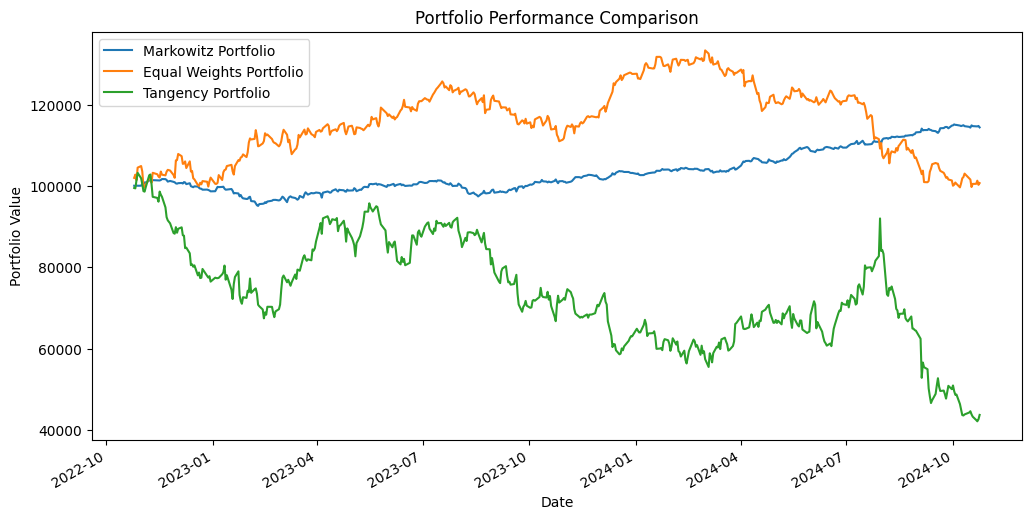

In [271]:
# Simulate the investment
simulation_results = simulate_investment(
    stock_returns=combined_returns_cleaned,
    risk_free_rate=risk_free_rate_cleaned,
    start_date='2022-10-25',
    end_date='2024-10-24',
    initial_capital=100000,
    min_return=0.13,
    calculate_minimum_risk_portfolio=calculate_minimum_risk_portfolio,
    return_variance_func=historical_mean_return_variance,
    tangency_weights=tangency_weights,
    tangency_weights_s=tangency_weights_s,
    short=True
)

simulation_results.plot(
    title="Portfolio Performance Comparison",
    ylabel="Portfolio Value",
    xlabel="Date",
    figsize=(12, 6)
);

In [256]:
def calculate_portfolio_statistics(portfolio_values):
    """
    Calculate various statistics for a portfolio.
    
    Parameters:
        portfolio_values (pd.Series): Daily portfolio values.
        risk_free_rate (float): Daily risk-free rate (constant or time series).

    Returns:
        dict: Statistics including annualized return, volatility, and Sharpe ratio.
    """
    daily_returns = portfolio_values.pct_change().dropna()
    annualized_return = (portfolio_values.iloc[-1] / 100000) ** (252 / len(portfolio_values)) - 1
    annualized_volatility = daily_returns.std() * (252 ** 0.5)

    return {
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility
    }

## 4.2 Portfolio Performance Comparison with S&P 500

The **S&P 500** index is a widely recognized benchmark in the investment world. To better assess our portfolio's performance, we introduced the S&P 500 as a comparison. Notably, every stock in our portfolio is part of the **S&P 500** index.  

According to [Wall Street Numbers](https://wallstreetnumbers.com/screeners/sp500), **GOOGL** is the sixth-largest company by market capitalization, making it the most influential stock from our portfolio in the index. Estimates suggest it holds a weight of approximately **2.1%** in the S&P 500, as reported by [WikiJob](https://www.wikijob.co.uk/trading/stocks/stocks-by-index-weight#top-10-sp-500-stocks-by-index-weight-2025) and [Investopedia](https://www.investopedia.com/top-25-stocks-in-the-s-and-p-500-september-2023-7853313#toc-top-25-sp-500-companies-by-market-cap). The second-largest stock from our portfolio, **AVGO**, has a weight of around **0.97%**. Given that these stocks represent only a small fraction of the index, we can reasonably assume that our portfolio behaves as a **semi-independent entity** rather than directly mirroring the S&P 500's movements.  

To analyze the S&P 500 alongside our portfolio, we imported the index data for the same period and computed the daily log returns. The figure below shows the **closing prices** (`Close`) and the corresponding **daily log returns** (`Daily`) of the S&P 500 index.  

From the plot, we observe that the index exhibits a general **upward trend**, with only a few short-lived declines. Furthermore, in terms of **daily log returns**, volatility appears to have **decreased towards the end of the period**, although we still see occasional negative spikes.


In [255]:
sp500_data[('Close', '^GSPC')] = pd.to_numeric(sp500_data[('Close', '^GSPC')], errors='coerce')
sp500_data[('Open', '^GSPC')] = pd.to_numeric(sp500_data[('Open', '^GSPC')], errors='coerce')
sp500_daily = np.log(sp500_data[('Close', '^GSPC')] / sp500_data[('Open', '^GSPC')])
sp500_return = np.round(sp500_daily.mean() * 252, 4).item()
sp500_std = np.round(sp500_daily.std() * np.sqrt(252), 4).item()

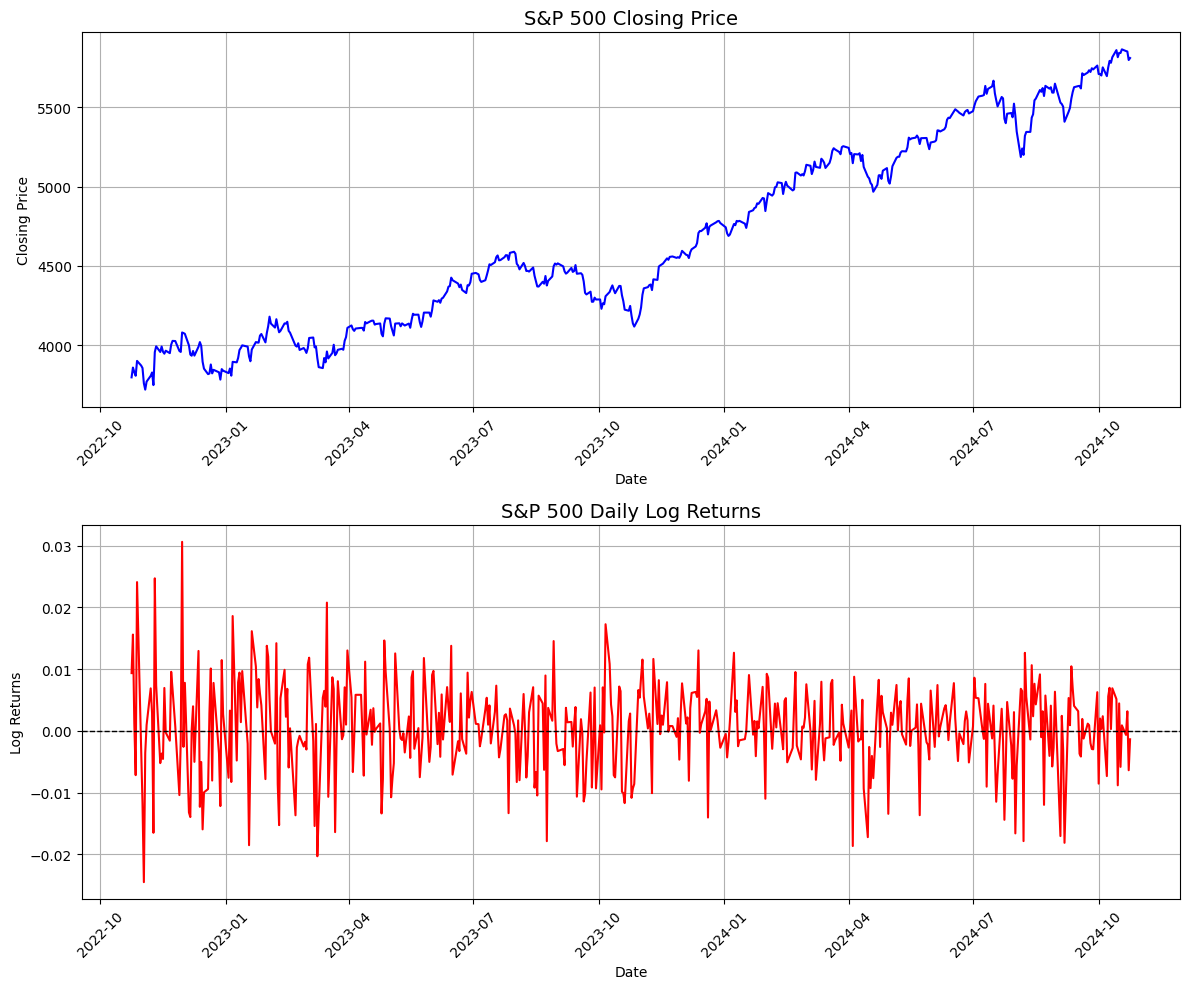

In [260]:
# Convert index to datetime if not already
sp500_data.index = pd.to_datetime(sp500_data.index)

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot Closing Prices
axes[0].plot(sp500_data.index, sp500_data[('Close', '^GSPC')], color='blue')
axes[0].set_title("S&P 500 Closing Price", fontsize=14)
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Closing Price")
axes[0].grid(True)
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[0].tick_params(axis='x', rotation=45)

# Plot Daily Log Returns
axes[1].plot(sp500_data.index, sp500_daily, color='red')
axes[1].set_title("S&P 500 Daily Log Returns", fontsize=14)
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Log Returns")
axes[1].grid(True)
axes[1].axhline(0, color='black', linewidth=1, linestyle='--')  # Zero return line
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

We normalized the **S&P 500** index to facilitate a better comparison with our portfolio's performance. In the plot below, we visualize the trajectory of the normalized **S&P 500** alongside the performance of our **equal-weighted portfolio**.

Some key observations we would like to note:
- At the start, the **S&P 500** trajectory closely follows the equal-weighted portfolio's path.
- However, around **Q2 2024**, the **S&P 500** begins to outperform the equal-weighted strategy, surpassing it in returns.
- Overall, the **S&P 500** emerges as the clear winner, with a higher return than all the other strategies, though it is accompanied by greater volatility.

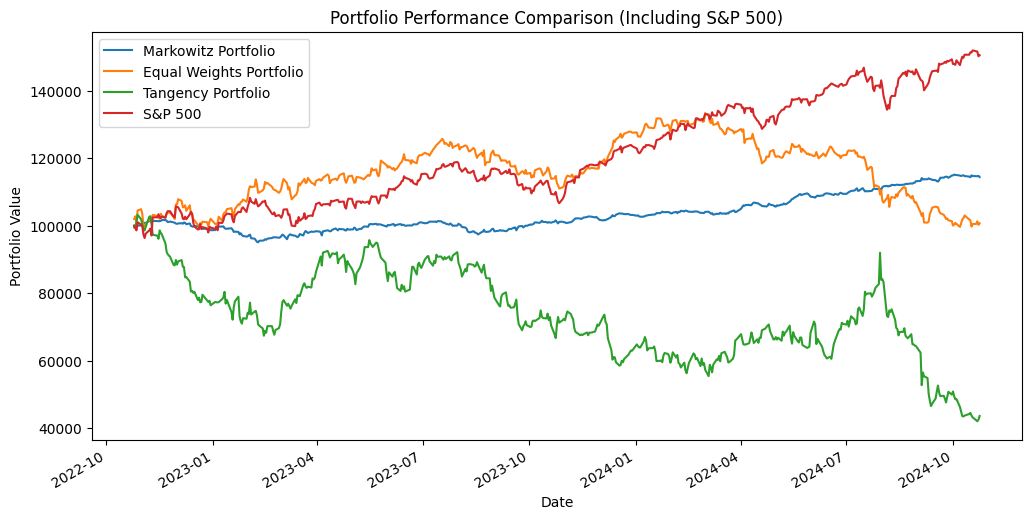

In [283]:
# Extract the S&P 500 closing prices and normalize to start at the same initial capital
sp500_close = sp500_data[('Close', '^GSPC')].loc['2022-10-25':'2024-10-24']
sp500_normalized = (sp500_close / sp500_close.iloc[0]) * 100000  # Scale to initial capital

# Merge S&P 500 with portfolio simulation results
simulation_results['S&P 500'] = sp500_normalized

# Plot all portfolios + S&P 500
simulation_results.plot(
    title="Portfolio Performance Comparison (Including S&P 500)",
    ylabel="Portfolio Value",
    xlabel="Date",
    figsize=(12, 6)
);


The **S&P 500** delivers the highest annualized return at **10.37%**, though it also comes with significant volatility at **11.43%**, indicating that it offers superior returns at a higher level of risk compared to the other portfolios. The **Markowitz Portfolio** provides a solid balance, with a **7.04% return** and relatively low volatility of **4.72%**, making it an attractive option for investors seeking a good risk-adjusted performance. On the other hand, the **Equal Weights Portfolio** offers a very modest return of **0.37%** but suffers from much higher volatility of **15.44%**, suggesting that it carries a high level of risk with minimal reward.

The **Tangency Portfolio** performs the worst, with a **-34.13% return** and **40.82% volatility**, indicating substantial losses and significant risk exposure. In conclusion, while the **S&P 500** outperforms the other portfolios in terms of returns, it does so with greater volatility, which may be acceptable for risk-tolerant investors. The **Markowitz Portfolio** offers a more conservative yet solid return, while the **Equal Weights Portfolio** and **Tangency Portfolio** seem less appealing due to their poor risk-return profiles.


In [265]:
table_data = []
for portfolio, (loss, peak_date, trough_date) in worst_losses.items():
    table_data.append([
        portfolio,
        f"{loss:.2%}",
        peak_date.strftime('%Y-%m-%d'),
        trough_date.strftime('%Y-%m-%d')
    ])

# Define headers
headers = ["Portfolio", "Worst Loss", "Peak Date", "Trough Date"]

# Print formatted table
print("\nWorst Loss for Each Portfolio:")
print(tabulate(table_data, headers=headers, tablefmt="grid"))

+-------------------------+---------------------+-------------------------+
| Portfolio               |   Annualized Return |   Annualized Volatility |
+=========================+=====================+=========================+
| Markowitz Portfolio     |              0.0704 |                  0.0472 |
+-------------------------+---------------------+-------------------------+
| Equal Weights Portfolio |              0.0037 |                  0.1544 |
+-------------------------+---------------------+-------------------------+
| Tangency Portfolio      |             -0.3413 |                  0.4082 |
+-------------------------+---------------------+-------------------------+
| S&P 500                 |              0.1037 |                  0.1143 |
+-------------------------+---------------------+-------------------------+


In [258]:
def calculate_worst_loss(portfolio_values):
    """
    Calculate the worst loss (maximum drawdown) for a portfolio.

    Parameters:
        portfolio_values (pd.Series): Portfolio values over time.

    Returns:
        float: Worst loss as the maximum drawdown.
    """
    # Calculate the running maximum value
    running_max = portfolio_values.cummax()
    
    # Calculate drawdown (difference between current value and running max)
    drawdown = (running_max - portfolio_values) / running_max
    
    # Find the maximum drawdown
    worst_loss = drawdown.max()
    trough_date = drawdown.idxmax().date()
    
    # Find the peak date (highest value before the trough)
    peak_date = portfolio_values[:trough_date].idxmax().date()
    
    return worst_loss, peak_date, trough_date

In [266]:
table_data = []
for portfolio, (loss, peak_date, trough_date) in worst_losses.items():
    table_data.append([
        portfolio,
        f"{loss:.2%}",
        peak_date.strftime('%Y-%m-%d'),
        trough_date.strftime('%Y-%m-%d')
    ])

# Define headers
headers = ["Portfolio", "Worst Loss", "Peak Date", "Trough Date"]

# Print formatted table
print("\nWorst Loss for Each Portfolio:")
print(tabulate(table_data, headers=headers, tablefmt="grid"))


Worst Loss for Each Portfolio:
+-------------------------+--------------+-------------+---------------+
| Portfolio               | Worst Loss   | Peak Date   | Trough Date   |
+=========================+==============+=============+===============+
| Markowitz Portfolio     | 6.52%        | 2022-11-08  | 2023-02-09    |
+-------------------------+--------------+-------------+---------------+
| Equal Weights Portfolio | 25.27%       | 2024-03-01  | 2024-10-07    |
+-------------------------+--------------+-------------+---------------+
| Tangency Portfolio      | 59.22%       | 2022-10-28  | 2024-10-22    |
+-------------------------+--------------+-------------+---------------+


The **Tangency Portfolio** has the worst loss of **59.22%**, which, if we had invested initially, would have cost us more than **60,000** in losses alone, not factoring in the potential opportunity cost of missing better investment opportunities. This significant loss suggests that the **Tangency Portfolio** is highly volatile and risky. The **Equal Weights Portfolio** also shows a considerable loss of **25.27%**, which, while lower, still represents a significant decline in value. The **Markowitz Portfolio**, on the other hand, offers the smallest worst loss of **6.52%**, indicating it is the least risky among the strategies.

In conclusion, the **Tangency Portfolio** presents the most substantial risk, with a large potential loss, while the **Markowitz Portfolio** seems the most prudent choice in terms of minimizing losses. The **Equal Weights Portfolio** falls in between, showing that its risk is high with little reward. The losses observed in these portfolios further emphasize the importance of risk management and strategic diversification in portfolio selection.

# Conclusion


In the first section, we prepared our data and conducted an in-depth analysis of individual stocks based on their **daily log returns** and **closing prices**. Examining price movements from **January 2021 to October 2024**, we identified distinct patterns among the selected stocks. Notably, **tech sector stocks** (**GOOGL, AVGO, QCOM, TXN**) exhibited strong correlations in their price movements, whereas other sectors showed greater independence. **DLTR** experienced a **sharp decline in late 2024**, while **ISRG** exhibited the **highest volatility**.

In the second section, we **simulated the efficient frontier**, excluding the risk-free rate and disallowing short sales. We then computed the **Sharpe ratio**, which led us to derive the **Capital Market Line (CML** and **Security Market Line (SML)** and identify the **Tangency Portfolio**, which consisted of only two tickers.  

The third section focused on **portfolio optimization with variance minimization**, subject to a **minimum return constraint of 10%**. We computed **optimal portfolio weights** under two scenarios:  
- **No short selling:** The portfolio relied heavily on the **risk-free asset**, leading to a **9% standard deviation**, while still maintaining the **target 10% return**.  
- **Short selling allowed:** The portfolio structure resembled the **Tangency Portfolio**, but with added exposure to the **risk-free asset**. This resulted in a **lower standard deviation of 5.5%**, making it a highly efficient choice for minimizing risk at the given return level.  

Finally, in the last section, we assessed our strategy by comparing four models:  
1. **Equal-weighted portfolio**  
2. **Tangency Portfolio**  
3. **Markowitz Portfolio**  
4. **S&P 500 Index**  

While the **Markowitz Portfolio** was profitable, it achieved only **mid-range expected returns**. The **S&P 500** remained the **best-performing strategy**, benefiting from its well-diversified structure. However, we noted that **raising the minimum return constraint** could potentially **improve expected results**, albeit at the cost of **higher risk**.  
